## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
# Find the given objects points and image points

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
     
def undistort_img(img):
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


### Test undistortion

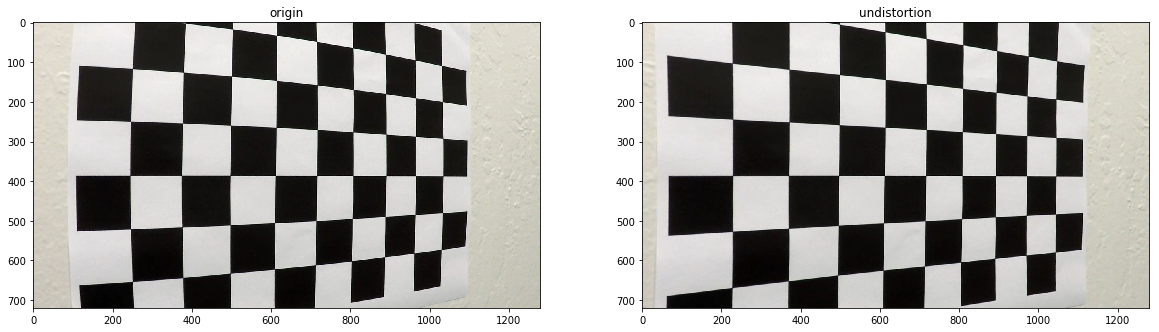

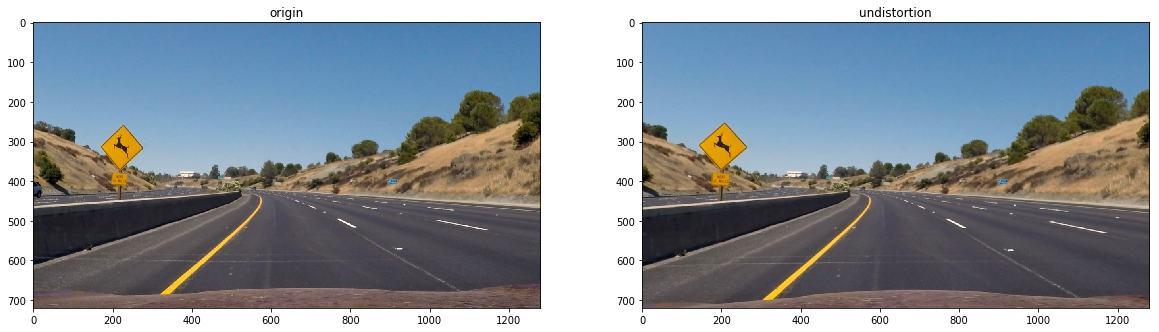

In [3]:

def test_undistort(img):
    dst = undistort_img(img)
    
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.title('origin')
    plt.imshow(img)

    plt.subplot(122)
    plt.title('undistortion')
    plt.imshow(dst)
    plt.show()


timg = mpimg.imread('camera_cal/calibration5.jpg')
test_undistort(timg)

timg = mpimg.imread('test_images/test2.jpg')
test_undistort(timg)


## Gradient threshold

In [4]:
def abs_sobel_thresh(img, orient = 'x', sobel_kernel =3,thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F,1,0,ksize = sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F,0,1,ksize = sobel_kernel))
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx= cv2.Sobel(gray, cv2.CV_64F,1,0, ksize = sobel_kernel)
    sobely= cv2.Sobel(gray, cv2.CV_64F,0,1, ksize = sobel_kernel)
    
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return binary_output

def dir_thresh(img, sobel_kernel = 3, dir_thresh= (0,np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx= cv2.Sobel(gray, cv2.CV_64F,1,0, ksize = sobel_kernel)
    sobely= cv2.Sobel(gray, cv2.CV_64F,0,1, ksize = sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    
    return binary_output


def color_thresh(img,color_thresh=(170,255)):

    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= color_thresh[0]) & (s_channel <= color_thresh[1])] = 1
    
    return s_binary


def combined_thresh(img):
    ksize = 3
    
    gradx = abs_sobel_thresh(img, orient='x',sobel_kernel=ksize, thresh=(30,100))
    grady = abs_sobel_thresh(img, orient='y',sobel_kernel=ksize, thresh=(30,100))
    mag_binary = mag_thresh(img,sobel_kernel=9, mag_thresh=(30,100))
    dir_binary = dir_thresh(img, sobel_kernel=15, dir_thresh = (0.7, 1.3))
    color_binary = color_thresh(img,color_thresh=(170,255))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx==1) & (grady ==1))|((mag_binary == 1) & (dir_binary ==1)) | (color_binary ==1)]=1
    
    return combined


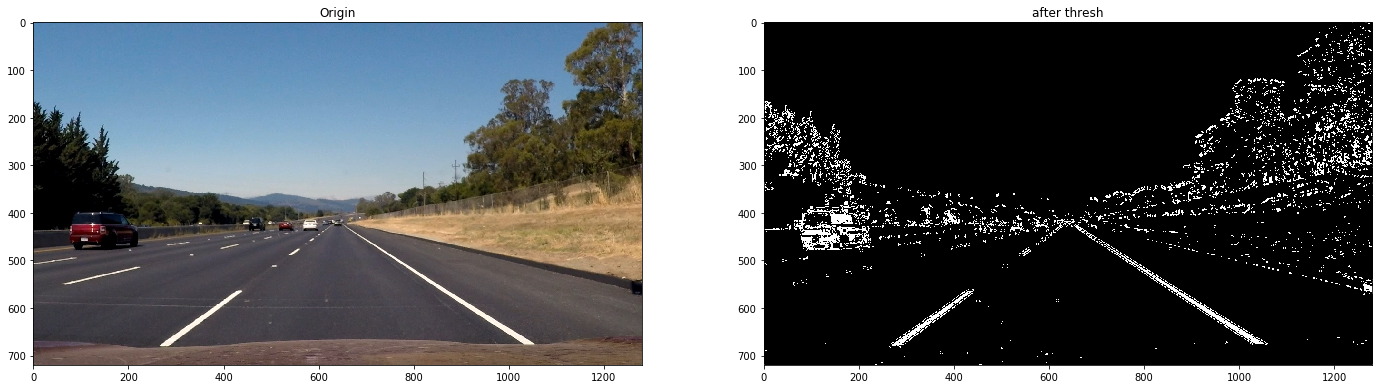

In [5]:
def test_thresh(img):
    comb = combined_thresh(img)

    f,(ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
    ax1.imshow(timg)
    ax1.set_title('Origin')
    ax2.imshow(comb, cmap='gray')
    ax2.set_title('after thresh')
    plt.show()
    

timg = mpimg.imread('test_images/straight_lines2.jpg')
test_thresh(timg)

## Perspective Transform

In [6]:

def warp_image(img):
    img_size = (img.shape[1], img.shape[0])
#     src = np.float32([[585,445],[690,445],[1035,670],[275,670]])
#     src = np.float32([[585,460],[695,460],[1127,720],[203,720]])
    src = np.float32([[585,460],[203,720],[1127,720],[695,460]])
    offset = 320
    dst = np.float32([[offset,0],[offset,img_size[1]],[img_size[0]-offset,img_size[1]],[img_size[0]-offset,0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return warped, Minv  

### Test Perspective

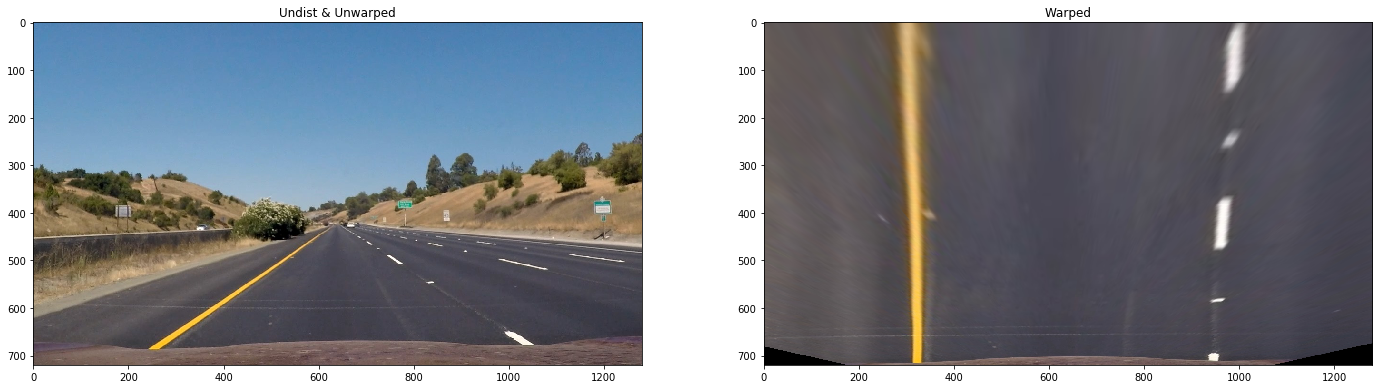

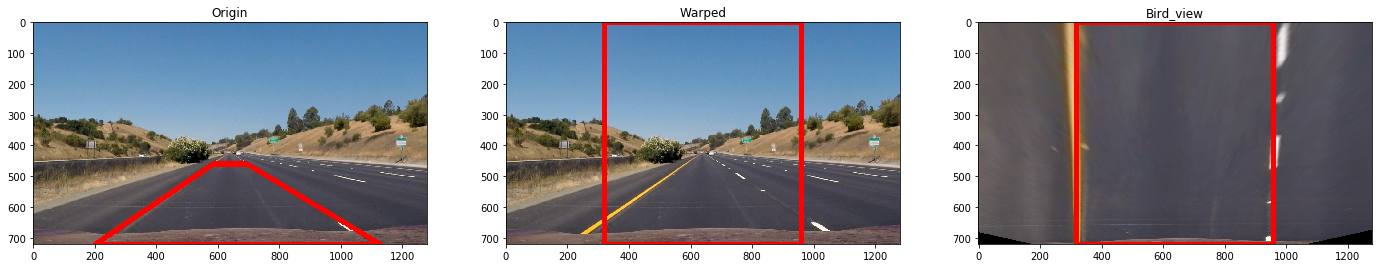

array([[[98, 90, 88],
        [97, 90, 88],
        [97, 89, 87],
        ..., 
        [72, 70, 83],
        [72, 70, 83],
        [72, 70, 83]],

       [[99, 91, 89],
        [98, 90, 88],
        [97, 89, 87],
        ..., 
        [72, 70, 83],
        [72, 70, 83],
        [72, 70, 83]],

       [[99, 91, 89],
        [98, 90, 88],
        [98, 90, 88],
        ..., 
        [72, 70, 83],
        [72, 70, 83],
        [72, 70, 83]],

       ..., 
       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ..., 
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ..., 
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ..., 
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

In [7]:
# %matplotlib qt4

def test_perspective(img):

    undist= undistort_img(img)
    warped_img, _ = warp_image(undist)
    f,(ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
    ax1.imshow(timg,cmap='gray')
    ax1.set_title('Undist & Unwarped')
    ax2.imshow(warped_img,cmap='gray')
    ax2.set_title('Warped')
    plt.show()


def perspective_transform(img):
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[585,460],[203,720],[1127,720],[695,460]])
    offset = 320
    dst = np.float32([[offset,0],[offset,img_size[1]],[img_size[0]-offset,img_size[1]],[img_size[0]-offset,0]])
    
    undist= undistort_img(img)
    warped, _ = warp_image(undist)
    
    src_img = img.copy()
    src_pts = src.reshape((-1, 1, 2)).astype("int32")
    cv2.polylines(src_img,[src_pts],True,(255,0,0),thickness = 15)
    
    dst_img = img.copy()
    dst_pts = dst.reshape((-1, 1, 2)).astype("int32")
    cv2.polylines(dst_img,[dst_pts],True,(255,0,0),thickness = 15)
    
    warped = warped.copy()
    dst_pts = dst.reshape((-1, 1, 2)).astype("int32")
    cv2.polylines(warped,[dst_pts],True,(255,0,0),thickness = 15)
    

    
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,9))
    ax1.imshow(src_img,cmap='gray')
    ax1.set_title('Origin')
    ax2.imshow(dst_img,cmap='gray')
    ax2.set_title('Warped')
    ax3.imshow(warped,cmap='gray')
    ax3.set_title('Bird_view')
    plt.show()
    
    return warped


timg = mpimg.imread('test_images/straight_lines1.jpg')
test_perspective(timg)
perspective_transform(timg)

## Lind Detections

In [8]:
def lane_lines_detections(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ################################################
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    out_img = np.uint8(out_img)
    
    return ploty, left_fitx, right_fitx, out_img, leftx, lefty, rightx, righty


    

### Visualization Line Detections

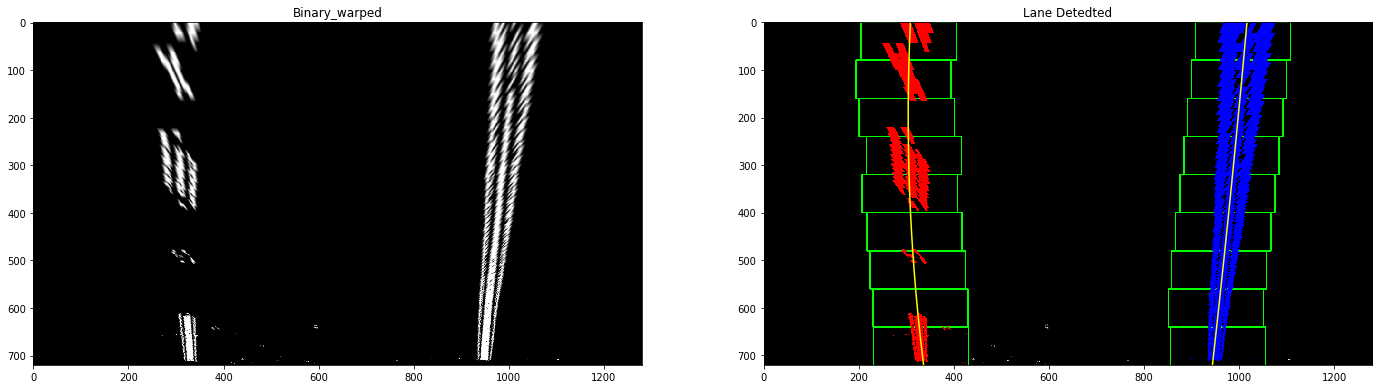

In [9]:
def visual_line_dections(img):
    img = undistort_img(img)
    img = combined_thresh(img)
    binary_warped, _= warp_image(img)
    ploty, left_fitx, right_fitx, out_img, _, _, _, _ = lane_lines_detections(binary_warped)
    
    f,(ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
    ax1.set_title('Binary_warped')
    ax1.imshow(binary_warped,cmap='gray')
   
    
    ax2.set_title('Lane Detedted')
    ax2.imshow(out_img, cmap='gray')
    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()

timg = mpimg.imread('test_images/straight_lines2.jpg')
visual_line_dections(timg)

In [10]:
def cal_lane_curv_and_vehicle_position(ploty, leftx, lefty, rightx, righty, image_size):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    
    lineLeft = left_fit_cr[0]*yMax**2 + left_fit_cr[1]*yMax + left_fit_cr[2]
    lineRight = right_fit_cr[0]*yMax**2 + right_fit_cr[1]*yMax + right_fit_cr[2]
    
    distacnce_from_center = np.absolute((lineRight + lineLeft)/2 - vehicleCenter)
    
    return left_curverad,right_curverad, distacnce_from_center

In [11]:
# def draw_lines_on_image(warped, undistorted_img, Minv, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty):
def draw_lines_on_image(warped, undistorted_img, Minv):
    
    ploty, left_fitx, right_fitx, out_img, leftx, lefty, rightx, righty = lane_lines_detections(warped)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    left_curvature,right_curverad,distance = cal_lane_curv_and_vehicle_position(ploty, leftx, lefty, rightx, righty, 0)
    cv2.putText(result, 'Radius of Curvature: Left = %.2f m, Right = %.2f m' % (left_curvature,right_curverad),  (20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    if distance < 0:
        veh_pos = 'left'
    else:
        veh_pos = 'right'
    cv2.putText(result, 'Vehicle is %.2fm %s from center' % (distance, veh_pos),  (20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    return result
    

In [12]:
def pipeline(img):
    undistorted_img = undistort_img(img)
    thresh = combined_thresh(undistorted_img)
    binary_warped, Minv = warp_image(thresh)
    image_with_lines = draw_lines_on_image(binary_warped, undistorted_img, Minv)
    return image_with_lines



### Test Pipeline

2946.2597438 m 277.637342256 m


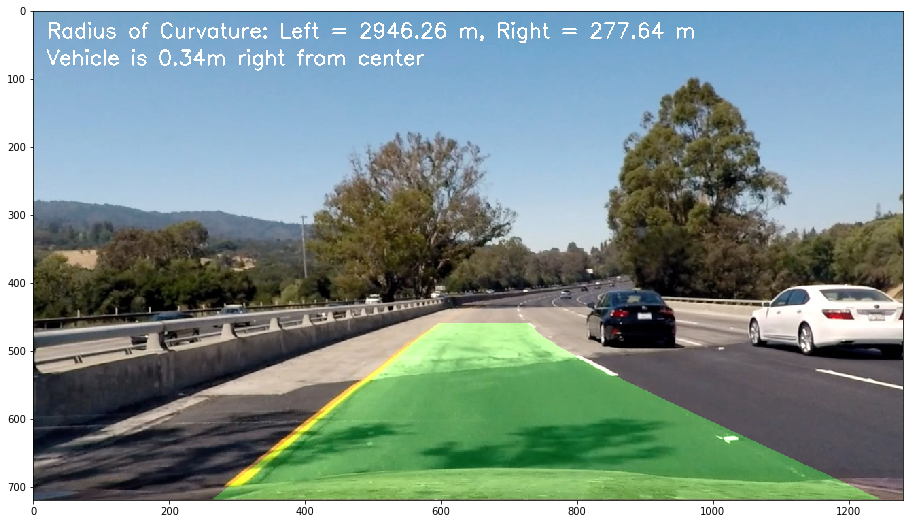

In [13]:
def test_pipeline(img):
    plt.figure(figsize=(24,9))
    processed_img = pipeline(timg)
    plt.imshow(processed_img)
    plt.show()
    
    
timg = mpimg.imread('test_images/test4.jpg')    
test_pipeline(timg)

### Run on the test Video

In [16]:
video_output = 'output_images/project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(pipeline)
%time video_clip.write_videofile(video_output, audio=False)

582.69030186 m 1293.52037802 m
[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4



  0%|          | 1/1261 [00:01<29:17,  1.40s/it]

582.69030186 m 1293.52037802 m



  0%|          | 2/1261 [00:02<29:12,  1.39s/it]

622.629996632 m 865.507347397 m



  0%|          | 3/1261 [00:04<28:34,  1.36s/it]

684.885876799 m 491.36503307 m



  0%|          | 4/1261 [00:05<27:56,  1.33s/it]

635.283390658 m 441.469803466 m



  0%|          | 5/1261 [00:06<29:13,  1.40s/it]

688.454861077 m 536.915899257 m



  0%|          | 6/1261 [00:08<28:28,  1.36s/it]

660.175700999 m 920.877034067 m



  1%|          | 7/1261 [00:09<28:22,  1.36s/it]

718.652925105 m 2618.0784591 m



  1%|          | 8/1261 [00:11<30:23,  1.46s/it]

732.257231953 m 627.541296539 m



  1%|          | 9/1261 [00:12<29:33,  1.42s/it]

720.444933304 m 500.384946451 m



  1%|          | 10/1261 [00:14<30:16,  1.45s/it]

756.718756192 m 1550.17137234 m



  1%|          | 11/1261 [00:15<31:25,  1.51s/it]

778.797120457 m 2261.9792526 m



  1%|          | 12/1261 [00:17<30:56,  1.49s/it]

771.651353401 m 1789.92266347 m



  1%|          | 13/1261 [00:18<28:58,  1.39s/it]

829.351880261 m 2067.89947455 m



  1%|          | 14/1261 [00:19<27:59,  1.35s/it]

790.978197088 m 27539.4443878 m



  1%|          | 15/1261 [00:21<29:33,  1.42s/it]

1052.83906785 m 553.726297197 m



  1%|▏         | 16/1261 [00:22<29:08,  1.40s/it]

1054.86893303 m 478.993709739 m



  1%|▏         | 17/1261 [00:24<29:40,  1.43s/it]

896.247549392 m 697.789898222 m



  1%|▏         | 18/1261 [00:25<31:22,  1.51s/it]

927.120611309 m 1633.4535863 m



  2%|▏         | 19/1261 [00:26<29:48,  1.44s/it]

1004.46348303 m 3554.39159596 m



  2%|▏         | 20/1261 [00:28<28:31,  1.38s/it]

1075.60032846 m 4101.45045246 m



  2%|▏         | 21/1261 [00:29<29:21,  1.42s/it]

1204.51118114 m 825.780183684 m



  2%|▏         | 22/1261 [00:31<29:23,  1.42s/it]

1298.56680433 m 634.912973342 m



  2%|▏         | 23/1261 [00:32<30:00,  1.45s/it]

1115.97644724 m 532.347640576 m



  2%|▏         | 24/1261 [00:33<29:02,  1.41s/it]

961.916332605 m 1168.34290824 m



  2%|▏         | 25/1261 [00:35<30:44,  1.49s/it]

912.054592227 m 838.670916752 m



  2%|▏         | 26/1261 [00:37<31:51,  1.55s/it]

994.712171769 m 1041.92002308 m



  2%|▏         | 27/1261 [00:38<31:25,  1.53s/it]

832.584548694 m 2002.37649305 m



  2%|▏         | 28/1261 [00:40<29:40,  1.44s/it]

826.454883975 m 3693.63886902 m



  2%|▏         | 29/1261 [00:41<29:16,  1.43s/it]

964.286506892 m 602.06484614 m



  2%|▏         | 30/1261 [00:42<29:36,  1.44s/it]

958.015656349 m 484.176750567 m



  2%|▏         | 31/1261 [00:44<27:56,  1.36s/it]

746.361174839 m 558.463936825 m



  3%|▎         | 32/1261 [00:45<27:09,  1.33s/it]

680.866682275 m 1571.9152716 m



  3%|▎         | 33/1261 [00:46<26:38,  1.30s/it]

657.698990682 m 2002.02875623 m



  3%|▎         | 34/1261 [00:48<27:52,  1.36s/it]

612.523312992 m 519.642277624 m



  3%|▎         | 35/1261 [00:49<26:53,  1.32s/it]

592.234040574 m 2263.39789747 m



  3%|▎         | 36/1261 [00:50<27:00,  1.32s/it]

568.113462575 m 1056.7288491 m



  3%|▎         | 37/1261 [00:51<26:03,  1.28s/it]

502.996227464 m 1008.72151457 m



  3%|▎         | 38/1261 [00:53<28:06,  1.38s/it]

486.404615628 m 804.120202449 m



  3%|▎         | 39/1261 [00:54<29:04,  1.43s/it]

490.025989408 m 457.826118206 m



  3%|▎         | 40/1261 [00:56<28:09,  1.38s/it]

496.614588486 m 408.78968566 m



  3%|▎         | 41/1261 [00:57<26:42,  1.31s/it]

487.159491604 m 442.196400988 m



  3%|▎         | 42/1261 [00:58<26:48,  1.32s/it]

496.716751161 m 460.48719952 m



  3%|▎         | 43/1261 [01:00<30:55,  1.52s/it]

553.188202233 m 495.02309972 m



  3%|▎         | 44/1261 [01:02<30:43,  1.51s/it]

594.139973072 m 700.699263315 m



  4%|▎         | 45/1261 [01:03<29:57,  1.48s/it]

573.125974842 m 1139.01279883 m



  4%|▎         | 46/1261 [01:05<29:35,  1.46s/it]

575.44736527 m 1526.98794167 m



  4%|▎         | 47/1261 [01:06<28:40,  1.42s/it]

625.415021506 m 768.328208499 m



  4%|▍         | 48/1261 [01:07<27:27,  1.36s/it]

616.238043603 m 5712.31024554 m



  4%|▍         | 49/1261 [01:08<27:03,  1.34s/it]

600.319385703 m 1935.17287466 m



  4%|▍         | 50/1261 [01:10<26:46,  1.33s/it]

626.400443551 m 1004.20947504 m



  4%|▍         | 51/1261 [01:11<25:55,  1.29s/it]

686.979171961 m 1079.91223283 m



  4%|▍         | 52/1261 [01:12<25:48,  1.28s/it]

649.087308225 m 721.483024527 m



  4%|▍         | 53/1261 [01:13<26:03,  1.29s/it]

807.772390167 m 452.617192551 m



  4%|▍         | 54/1261 [01:15<25:23,  1.26s/it]

787.270859879 m 458.244981641 m



  4%|▍         | 55/1261 [01:16<26:36,  1.32s/it]

976.641601709 m 447.227462989 m



  4%|▍         | 56/1261 [01:17<26:38,  1.33s/it]

1065.95918704 m 596.475822939 m



  5%|▍         | 57/1261 [01:19<26:17,  1.31s/it]

1087.724063 m 972.247399101 m



  5%|▍         | 58/1261 [01:20<25:58,  1.30s/it]

1130.53912634 m 3192.29614428 m



  5%|▍         | 59/1261 [01:21<25:34,  1.28s/it]

961.213319117 m 32303.2148173 m



  5%|▍         | 60/1261 [01:22<25:29,  1.27s/it]

894.430479595 m 1197.09575523 m



  5%|▍         | 61/1261 [01:24<25:05,  1.25s/it]

914.210755688 m 1472.58595409 m



  5%|▍         | 62/1261 [01:25<25:07,  1.26s/it]

901.304504408 m 702.528111505 m



  5%|▍         | 63/1261 [01:26<24:57,  1.25s/it]

1009.86021917 m 689.558694622 m



  5%|▌         | 64/1261 [01:27<25:01,  1.25s/it]

941.97937623 m 513.437968126 m



  5%|▌         | 65/1261 [01:29<25:10,  1.26s/it]

818.012894574 m 559.920847186 m



  5%|▌         | 66/1261 [01:30<24:46,  1.24s/it]

713.731754235 m 612.301387274 m



  5%|▌         | 67/1261 [01:31<24:31,  1.23s/it]

638.283864585 m 795.466591234 m



  5%|▌         | 68/1261 [01:33<27:24,  1.38s/it]

706.274928334 m 1282.84312953 m



  5%|▌         | 69/1261 [01:34<28:48,  1.45s/it]

742.780004672 m 2663.56338605 m



  6%|▌         | 70/1261 [01:36<28:06,  1.42s/it]

830.861579957 m 16307.6038936 m



  6%|▌         | 71/1261 [01:37<28:09,  1.42s/it]

841.917782798 m 12244.2975506 m



  6%|▌         | 72/1261 [01:39<29:07,  1.47s/it]

863.819795602 m 2093.39252121 m



  6%|▌         | 73/1261 [01:40<28:41,  1.45s/it]

833.297998834 m 1349.49420556 m



  6%|▌         | 74/1261 [01:42<28:11,  1.42s/it]

872.312230329 m 1091.97125387 m



  6%|▌         | 75/1261 [01:43<28:00,  1.42s/it]

1036.17690643 m 906.992929291 m



  6%|▌         | 76/1261 [01:45<29:09,  1.48s/it]

1103.41486464 m 527.320835213 m



  6%|▌         | 77/1261 [01:46<27:39,  1.40s/it]

1360.75770767 m 542.647668024 m



  6%|▌         | 78/1261 [01:47<26:27,  1.34s/it]

1776.66185298 m 524.842209999 m



  6%|▋         | 79/1261 [01:48<25:50,  1.31s/it]

1613.45743271 m 443.585659072 m



  6%|▋         | 80/1261 [01:50<25:34,  1.30s/it]

1577.5519748 m 409.158829669 m



  6%|▋         | 81/1261 [01:51<24:40,  1.25s/it]

1300.69937509 m 575.65274696 m



  7%|▋         | 82/1261 [01:52<26:10,  1.33s/it]

1276.40313639 m 806.650088167 m



  7%|▋         | 83/1261 [01:54<28:05,  1.43s/it]

1156.70117363 m 56736.5675873 m



  7%|▋         | 84/1261 [01:55<27:01,  1.38s/it]

1213.83380218 m 1072.26478367 m



  7%|▋         | 85/1261 [01:56<26:02,  1.33s/it]

1014.81797212 m 702.40481508 m



  7%|▋         | 86/1261 [01:58<25:33,  1.31s/it]

842.965879972 m 700.560230421 m



  7%|▋         | 87/1261 [01:59<25:03,  1.28s/it]

767.296222193 m 1171.11967274 m



  7%|▋         | 88/1261 [02:00<25:56,  1.33s/it]

737.871399968 m 1125.84656863 m



  7%|▋         | 89/1261 [02:02<25:47,  1.32s/it]

766.706705982 m 573.410222551 m



  7%|▋         | 90/1261 [02:03<26:33,  1.36s/it]

669.531686564 m 477.567607921 m



  7%|▋         | 91/1261 [02:05<28:59,  1.49s/it]

650.681180952 m 517.502756612 m



  7%|▋         | 92/1261 [02:07<30:29,  1.57s/it]

671.392384858 m 590.127209551 m



  7%|▋         | 93/1261 [02:08<31:57,  1.64s/it]

703.284507299 m 991.736043181 m



  7%|▋         | 94/1261 [02:10<31:28,  1.62s/it]

713.593520486 m 1909.68526627 m



  8%|▊         | 95/1261 [02:12<36:45,  1.89s/it]

721.834677965 m 14840.3627695 m



  8%|▊         | 96/1261 [02:14<37:30,  1.93s/it]

734.925609706 m 1418.39055132 m



  8%|▊         | 97/1261 [02:16<37:34,  1.94s/it]

652.889071732 m 19495.2519202 m



  8%|▊         | 98/1261 [02:18<34:44,  1.79s/it]

698.905014366 m 2453.79596913 m



  8%|▊         | 99/1261 [02:19<32:06,  1.66s/it]

696.53397385 m 854.614076863 m



  8%|▊         | 100/1261 [02:21<30:41,  1.59s/it]

687.096581735 m 870.848461551 m



  8%|▊         | 101/1261 [02:22<29:19,  1.52s/it]

777.668670942 m 653.568060339 m



  8%|▊         | 102/1261 [02:24<29:09,  1.51s/it]

913.224703397 m 511.235752057 m



  8%|▊         | 103/1261 [02:25<31:29,  1.63s/it]

841.268095646 m 440.225002492 m



  8%|▊         | 104/1261 [02:27<30:44,  1.59s/it]

777.430559125 m 444.349513424 m



  8%|▊         | 105/1261 [02:28<30:01,  1.56s/it]

860.688135523 m 447.52554512 m



  8%|▊         | 106/1261 [02:30<30:31,  1.59s/it]

846.284074187 m 509.792617593 m



  8%|▊         | 107/1261 [02:32<31:48,  1.65s/it]

923.668856599 m 591.866696887 m



  9%|▊         | 108/1261 [02:34<34:34,  1.80s/it]

800.390411898 m 1548.73700171 m



  9%|▊         | 109/1261 [02:36<34:51,  1.82s/it]

782.323784709 m 1593.60641595 m



  9%|▊         | 110/1261 [02:38<37:53,  1.98s/it]

714.294948152 m 1014.31605028 m



  9%|▉         | 111/1261 [02:40<37:57,  1.98s/it]

677.736321111 m 3475.73131552 m



  9%|▉         | 112/1261 [02:42<35:51,  1.87s/it]

707.197381884 m 1537.89570321 m



  9%|▉         | 113/1261 [02:43<33:27,  1.75s/it]

681.289419901 m 914.186348113 m



  9%|▉         | 114/1261 [02:45<31:44,  1.66s/it]

646.871520587 m 811.143792024 m



  9%|▉         | 115/1261 [02:46<29:31,  1.55s/it]

674.359479153 m 482.381034995 m



  9%|▉         | 116/1261 [02:47<28:27,  1.49s/it]

644.406630679 m 403.3945068 m



  9%|▉         | 117/1261 [02:49<27:16,  1.43s/it]

622.894628792 m 425.022797997 m



  9%|▉         | 118/1261 [02:50<28:53,  1.52s/it]

680.348378881 m 506.448081782 m



  9%|▉         | 119/1261 [02:53<34:04,  1.79s/it]

638.142857206 m 734.251918918 m



 10%|▉         | 120/1261 [02:55<35:59,  1.89s/it]

613.445825743 m 1895.19539218 m



 10%|▉         | 121/1261 [02:57<37:58,  2.00s/it]

623.410561063 m 3847.45075305 m



 10%|▉         | 122/1261 [03:00<40:38,  2.14s/it]

581.442212017 m 12335.3752711 m



 10%|▉         | 123/1261 [03:02<39:11,  2.07s/it]

564.42335486 m 870.792958403 m



 10%|▉         | 124/1261 [03:03<38:17,  2.02s/it]

563.801178599 m 1071.36701817 m



 10%|▉         | 125/1261 [03:05<35:09,  1.86s/it]

569.79448465 m 699.016748599 m



 10%|▉         | 126/1261 [03:07<34:36,  1.83s/it]

598.224164545 m 697.74967616 m



 10%|█         | 127/1261 [03:08<34:01,  1.80s/it]

614.300699576 m 420.910575469 m



 10%|█         | 128/1261 [03:11<36:31,  1.93s/it]

668.307884581 m 423.06716997 m



 10%|█         | 129/1261 [03:12<33:18,  1.77s/it]

618.361604995 m 492.633608965 m



 10%|█         | 130/1261 [03:13<31:05,  1.65s/it]

673.924435743 m 571.865701857 m



 10%|█         | 131/1261 [03:15<29:10,  1.55s/it]

673.557216429 m 883.703722081 m



 10%|█         | 132/1261 [03:16<29:43,  1.58s/it]

656.203286591 m 1179.66992098 m



 11%|█         | 133/1261 [03:18<29:11,  1.55s/it]

689.468804912 m 1187.52487365 m



 11%|█         | 134/1261 [03:19<28:45,  1.53s/it]

688.034526591 m 2276.52683867 m



 11%|█         | 135/1261 [03:21<28:02,  1.49s/it]

741.458888444 m 1596.12257901 m



 11%|█         | 136/1261 [03:22<27:58,  1.49s/it]

732.959583556 m 1035.7440441 m



 11%|█         | 137/1261 [03:24<27:12,  1.45s/it]

843.863618909 m 1008.41408856 m



 11%|█         | 138/1261 [03:25<26:51,  1.43s/it]

905.772219606 m 1404.56227338 m



 11%|█         | 139/1261 [03:27<27:35,  1.48s/it]

858.10765411 m 2099.95215014 m



 11%|█         | 140/1261 [03:28<27:12,  1.46s/it]

1000.64007048 m 1688.38693668 m



 11%|█         | 141/1261 [03:29<26:55,  1.44s/it]

1025.14377632 m 564.426698674 m



 11%|█▏        | 142/1261 [03:31<25:31,  1.37s/it]

841.794765489 m 497.391878721 m



 11%|█▏        | 143/1261 [03:32<24:25,  1.31s/it]

769.577342809 m 710.088089277 m



 11%|█▏        | 144/1261 [03:33<23:45,  1.28s/it]

823.464889079 m 1191.63589138 m



 11%|█▏        | 145/1261 [03:34<23:31,  1.27s/it]

830.966793423 m 2887.27658434 m



 12%|█▏        | 146/1261 [03:35<23:04,  1.24s/it]

904.381484972 m 2197.73349265 m



 12%|█▏        | 147/1261 [03:37<22:37,  1.22s/it]

906.450148194 m 30676.8435561 m



 12%|█▏        | 148/1261 [03:38<22:58,  1.24s/it]

938.579442913 m 1005.70655868 m



 12%|█▏        | 149/1261 [03:39<23:46,  1.28s/it]

976.696155535 m 868.963664386 m



 12%|█▏        | 150/1261 [03:40<23:08,  1.25s/it]

1029.61494801 m 690.802723043 m



 12%|█▏        | 151/1261 [03:42<24:27,  1.32s/it]

1036.69099894 m 596.090336052 m



 12%|█▏        | 152/1261 [03:43<24:11,  1.31s/it]

1145.66656667 m 463.852399032 m



 12%|█▏        | 153/1261 [03:44<23:52,  1.29s/it]

978.6850284 m 440.854298452 m



 12%|█▏        | 154/1261 [03:46<24:34,  1.33s/it]

951.968656333 m 454.038773296 m



 12%|█▏        | 155/1261 [03:47<24:46,  1.34s/it]

1019.1777068 m 508.352282721 m



 12%|█▏        | 156/1261 [03:49<25:09,  1.37s/it]

1026.49875591 m 716.034094535 m



 12%|█▏        | 157/1261 [03:50<24:28,  1.33s/it]

865.396927872 m 1229.5064764 m



 13%|█▎        | 158/1261 [03:51<23:25,  1.27s/it]

818.209928559 m 4033.90545237 m



 13%|█▎        | 159/1261 [03:52<22:46,  1.24s/it]

844.699699364 m 865.664180568 m



 13%|█▎        | 160/1261 [03:53<22:58,  1.25s/it]

767.816017938 m 10145.1085243 m



 13%|█▎        | 161/1261 [03:55<23:31,  1.28s/it]

775.317673834 m 2635.56333662 m



 13%|█▎        | 162/1261 [03:56<24:37,  1.34s/it]

770.447265302 m 1992.34323192 m



 13%|█▎        | 163/1261 [03:58<24:00,  1.31s/it]

757.421246359 m 3959.6394586 m



 13%|█▎        | 164/1261 [03:59<24:30,  1.34s/it]

816.990363471 m 1087.53702088 m



 13%|█▎        | 165/1261 [04:00<24:05,  1.32s/it]

793.555065737 m 479.165648664 m



 13%|█▎        | 166/1261 [04:02<23:43,  1.30s/it]

793.803943868 m 498.252329369 m



 13%|█▎        | 167/1261 [04:03<23:22,  1.28s/it]

729.049624563 m 730.669021216 m



 13%|█▎        | 168/1261 [04:04<23:52,  1.31s/it]

762.853318675 m 766.405738086 m



 13%|█▎        | 169/1261 [04:05<23:57,  1.32s/it]

813.128864366 m 1028.92106923 m



 13%|█▎        | 170/1261 [04:07<23:19,  1.28s/it]

807.090047078 m 1677.39110606 m



 14%|█▎        | 171/1261 [04:08<23:55,  1.32s/it]

899.085623907 m 2768.7674612 m



 14%|█▎        | 172/1261 [04:10<24:38,  1.36s/it]

878.30437942 m 5339.48396337 m



 14%|█▎        | 173/1261 [04:11<26:21,  1.45s/it]

953.845947852 m 574.829060255 m



 14%|█▍        | 174/1261 [04:13<27:18,  1.51s/it]

905.610402676 m 560.331468574 m



 14%|█▍        | 175/1261 [04:14<26:14,  1.45s/it]

895.7343107 m 384.841438313 m



 14%|█▍        | 176/1261 [04:16<25:54,  1.43s/it]

848.758198376 m 276.387344144 m



 14%|█▍        | 177/1261 [04:17<25:43,  1.42s/it]

919.462223515 m 303.302317363 m



 14%|█▍        | 178/1261 [04:19<27:44,  1.54s/it]

799.70758505 m 308.331737491 m



 14%|█▍        | 179/1261 [04:20<27:00,  1.50s/it]

798.450123661 m 342.724896777 m



 14%|█▍        | 180/1261 [04:22<27:31,  1.53s/it]

784.515184548 m 393.141432893 m



 14%|█▍        | 181/1261 [04:23<27:20,  1.52s/it]

711.461252634 m 613.319656042 m



 14%|█▍        | 182/1261 [04:25<29:42,  1.65s/it]

708.004824382 m 817.743025599 m



 15%|█▍        | 183/1261 [04:27<28:03,  1.56s/it]

649.586283119 m 7120.2361967 m



 15%|█▍        | 184/1261 [04:28<27:26,  1.53s/it]

610.098490264 m 1556.63138464 m



 15%|█▍        | 185/1261 [04:29<27:09,  1.51s/it]

571.576161794 m 1017.65180787 m



 15%|█▍        | 186/1261 [04:31<27:37,  1.54s/it]

529.294505509 m 411.272693387 m



 15%|█▍        | 187/1261 [04:32<26:51,  1.50s/it]

526.691656567 m 335.667936274 m



 15%|█▍        | 188/1261 [04:34<26:04,  1.46s/it]

491.725198273 m 408.975120685 m



 15%|█▍        | 189/1261 [04:35<25:14,  1.41s/it]

497.392186763 m 493.944746106 m



 15%|█▌        | 190/1261 [04:37<26:12,  1.47s/it]

493.583282683 m 645.027852162 m



 15%|█▌        | 191/1261 [04:39<28:37,  1.61s/it]

453.656358577 m 988.313910082 m



 15%|█▌        | 192/1261 [04:40<27:39,  1.55s/it]

526.508131011 m 1013.48676458 m



 15%|█▌        | 193/1261 [04:41<26:21,  1.48s/it]

546.043915348 m 917.899388419 m



 15%|█▌        | 194/1261 [04:43<25:04,  1.41s/it]

556.991268015 m 842.473808806 m



 15%|█▌        | 195/1261 [04:44<24:50,  1.40s/it]

554.891156216 m 741.452548538 m



 16%|█▌        | 196/1261 [04:45<24:36,  1.39s/it]

676.782227314 m 1775.14224723 m



 16%|█▌        | 197/1261 [04:47<24:24,  1.38s/it]

690.700556853 m 1595.38353516 m



 16%|█▌        | 198/1261 [04:48<25:27,  1.44s/it]

809.363554738 m 594.902309553 m



 16%|█▌        | 199/1261 [04:50<24:15,  1.37s/it]

756.710360112 m 579.580058122 m



 16%|█▌        | 200/1261 [04:51<24:31,  1.39s/it]

806.284859485 m 1530.90380932 m



 16%|█▌        | 201/1261 [04:52<24:35,  1.39s/it]

753.607443968 m 703.618706595 m



 16%|█▌        | 202/1261 [04:54<25:19,  1.43s/it]

779.091617083 m 1239.47461157 m



 16%|█▌        | 203/1261 [04:55<24:37,  1.40s/it]

893.970386115 m 644.101665818 m



 16%|█▌        | 204/1261 [04:57<24:39,  1.40s/it]

855.848443649 m 443.163426929 m



 16%|█▋        | 205/1261 [04:58<24:41,  1.40s/it]

860.899249926 m 485.71234091 m



 16%|█▋        | 206/1261 [04:59<23:59,  1.36s/it]

835.587920387 m 708.119721945 m



 16%|█▋        | 207/1261 [05:01<27:17,  1.55s/it]

728.443749902 m 5540.99903523 m



 16%|█▋        | 208/1261 [05:03<27:54,  1.59s/it]

653.348652712 m 2476.21160625 m



 17%|█▋        | 209/1261 [05:04<27:15,  1.56s/it]

653.428089794 m 7566.48096757 m



 17%|█▋        | 210/1261 [05:06<27:38,  1.58s/it]

658.270399976 m 1256.17181074 m



 17%|█▋        | 211/1261 [05:08<27:34,  1.58s/it]

683.188057302 m 832.733842107 m



 17%|█▋        | 212/1261 [05:09<26:56,  1.54s/it]

676.049926527 m 1050.89154641 m



 17%|█▋        | 213/1261 [05:11<26:18,  1.51s/it]

648.83590563 m 1343.70095634 m



 17%|█▋        | 214/1261 [05:13<30:30,  1.75s/it]

628.658510274 m 636.590577538 m



 17%|█▋        | 215/1261 [05:15<30:40,  1.76s/it]

644.886521223 m 464.964547667 m



 17%|█▋        | 216/1261 [05:16<30:49,  1.77s/it]

622.736122876 m 489.796428223 m



 17%|█▋        | 217/1261 [05:18<31:28,  1.81s/it]

627.266633537 m 573.531683682 m



 17%|█▋        | 218/1261 [05:20<30:59,  1.78s/it]

678.760711606 m 698.911787561 m



 17%|█▋        | 219/1261 [05:22<30:52,  1.78s/it]

649.106866066 m 2187.73254873 m



 17%|█▋        | 220/1261 [05:23<29:25,  1.70s/it]

714.72910656 m 3059.86733766 m



 18%|█▊        | 221/1261 [05:25<28:18,  1.63s/it]

754.150583025 m 736.066964005 m



 18%|█▊        | 222/1261 [05:26<26:53,  1.55s/it]

762.728878102 m 2080.85879696 m



 18%|█▊        | 223/1261 [05:27<25:07,  1.45s/it]

726.954333584 m 1663.70278712 m



 18%|█▊        | 224/1261 [05:29<24:52,  1.44s/it]

734.876576516 m 1564.26005997 m



 18%|█▊        | 225/1261 [05:30<24:09,  1.40s/it]

878.252064476 m 1061.37531846 m



 18%|█▊        | 226/1261 [05:31<23:24,  1.36s/it]

809.502086013 m 509.260105392 m



 18%|█▊        | 227/1261 [05:33<22:49,  1.32s/it]

821.622803348 m 476.131079966 m



 18%|█▊        | 228/1261 [05:34<23:13,  1.35s/it]

737.281950571 m 534.47862433 m



 18%|█▊        | 229/1261 [05:35<23:39,  1.38s/it]

806.463521642 m 584.826248324 m



 18%|█▊        | 230/1261 [05:37<23:32,  1.37s/it]

827.104503845 m 639.637972747 m



 18%|█▊        | 231/1261 [05:38<23:52,  1.39s/it]

786.006674328 m 1073.52609571 m



 18%|█▊        | 232/1261 [05:40<23:34,  1.37s/it]

828.475404344 m 3878.84469845 m



 18%|█▊        | 233/1261 [05:41<23:12,  1.35s/it]

842.852285013 m 921.301584829 m



 19%|█▊        | 234/1261 [05:42<23:03,  1.35s/it]

883.716751014 m 5629.05928705 m



 19%|█▊        | 235/1261 [05:44<22:48,  1.33s/it]

935.893300291 m 1098.85128981 m



 19%|█▊        | 236/1261 [05:45<23:25,  1.37s/it]

1027.86334706 m 974.920195904 m



 19%|█▉        | 237/1261 [05:46<23:42,  1.39s/it]

1034.38979338 m 739.247178334 m



 19%|█▉        | 238/1261 [05:48<23:53,  1.40s/it]

797.691282758 m 365.056002189 m



 19%|█▉        | 239/1261 [05:49<24:07,  1.42s/it]

683.469403006 m 407.66108744 m



 19%|█▉        | 240/1261 [05:51<23:48,  1.40s/it]

721.067681758 m 429.495409164 m



 19%|█▉        | 241/1261 [05:52<24:18,  1.43s/it]

704.162755586 m 535.773989955 m



 19%|█▉        | 242/1261 [05:54<25:59,  1.53s/it]

703.538005836 m 593.802306497 m



 19%|█▉        | 243/1261 [05:55<25:35,  1.51s/it]

693.099865842 m 948.752010094 m



 19%|█▉        | 244/1261 [05:57<25:08,  1.48s/it]

694.961909694 m 1626.31177056 m



 19%|█▉        | 245/1261 [05:58<25:19,  1.50s/it]

661.238628202 m 1602.90378119 m



 20%|█▉        | 246/1261 [06:00<25:37,  1.51s/it]

686.849587405 m 1147.1443416 m



 20%|█▉        | 247/1261 [06:02<27:30,  1.63s/it]

756.645308464 m 1127.13547552 m



 20%|█▉        | 248/1261 [06:03<26:24,  1.56s/it]

655.309927361 m 479.097195017 m



 20%|█▉        | 249/1261 [06:04<24:57,  1.48s/it]

668.45930458 m 393.391570716 m



 20%|█▉        | 250/1261 [06:06<23:16,  1.38s/it]

634.854345797 m 381.414726358 m



 20%|█▉        | 251/1261 [06:07<22:23,  1.33s/it]

642.197608716 m 411.284713123 m



 20%|█▉        | 252/1261 [06:09<27:30,  1.64s/it]

664.189758374 m 484.588931323 m



 20%|██        | 253/1261 [06:11<26:46,  1.59s/it]

659.608596814 m 633.703310409 m



 20%|██        | 254/1261 [06:12<25:25,  1.51s/it]

716.863554045 m 699.220113416 m



 20%|██        | 255/1261 [06:14<26:16,  1.57s/it]

737.434830505 m 1473.61870401 m



 20%|██        | 256/1261 [06:15<27:06,  1.62s/it]

719.28572527 m 1446.82834479 m



 20%|██        | 257/1261 [06:17<25:16,  1.51s/it]

716.873905401 m 785.391913417 m



 20%|██        | 258/1261 [06:18<24:54,  1.49s/it]

716.154006805 m 666.264259389 m



 21%|██        | 259/1261 [06:19<24:01,  1.44s/it]

735.688245045 m 623.691399801 m



 21%|██        | 260/1261 [06:21<25:03,  1.50s/it]

856.992143641 m 518.494346269 m



 21%|██        | 261/1261 [06:23<26:33,  1.59s/it]

871.35291396 m 564.964136652 m



 21%|██        | 262/1261 [06:24<26:14,  1.58s/it]

763.490799025 m 375.15735402 m



 21%|██        | 263/1261 [06:26<27:20,  1.64s/it]

805.407732948 m 395.845297979 m



 21%|██        | 264/1261 [06:28<26:54,  1.62s/it]

779.074101872 m 448.309059236 m



 21%|██        | 265/1261 [06:30<28:03,  1.69s/it]

787.572427058 m 510.871656137 m



 21%|██        | 266/1261 [06:31<27:19,  1.65s/it]

765.135278525 m 560.751782595 m



 21%|██        | 267/1261 [06:33<26:01,  1.57s/it]

748.603202031 m 984.968643029 m



 21%|██▏       | 268/1261 [06:34<25:43,  1.55s/it]

770.532576188 m 1864.44274914 m



 21%|██▏       | 269/1261 [06:36<26:12,  1.59s/it]

800.210652696 m 19465.0149319 m



 21%|██▏       | 270/1261 [06:37<26:46,  1.62s/it]

868.768239959 m 1414.56709612 m



 21%|██▏       | 271/1261 [06:39<25:22,  1.54s/it]

851.82567965 m 1562.45827079 m



 22%|██▏       | 272/1261 [06:40<24:53,  1.51s/it]

779.084285448 m 1156.73158786 m



 22%|██▏       | 273/1261 [06:42<25:30,  1.55s/it]

775.972010097 m 776.507867694 m



 22%|██▏       | 274/1261 [06:43<25:29,  1.55s/it]

743.126465587 m 499.54322064 m



 22%|██▏       | 275/1261 [06:45<26:44,  1.63s/it]

724.957464156 m 606.651700889 m



 22%|██▏       | 276/1261 [06:47<26:01,  1.58s/it]

760.30878928 m 617.129138209 m



 22%|██▏       | 277/1261 [06:48<24:09,  1.47s/it]

848.47099405 m 762.895964958 m



 22%|██▏       | 278/1261 [06:49<22:59,  1.40s/it]

940.971078887 m 927.111989717 m



 22%|██▏       | 279/1261 [06:51<23:02,  1.41s/it]

982.979206971 m 2344.38917995 m



 22%|██▏       | 280/1261 [06:53<28:25,  1.74s/it]

962.320115633 m 36497.7192067 m



 22%|██▏       | 281/1261 [06:55<27:12,  1.67s/it]

979.942759539 m 6097.11765279 m



 22%|██▏       | 282/1261 [06:56<25:56,  1.59s/it]

1106.46731364 m 1844.29392375 m



 22%|██▏       | 283/1261 [06:58<28:11,  1.73s/it]

1149.28780812 m 1938.81358586 m



 23%|██▎       | 284/1261 [07:00<27:06,  1.67s/it]

1235.9751403 m 3263.23823021 m



 23%|██▎       | 285/1261 [07:01<24:49,  1.53s/it]

1384.11899001 m 2002.07210131 m



 23%|██▎       | 286/1261 [07:02<23:27,  1.44s/it]

1419.99658905 m 2198.60692327 m



 23%|██▎       | 287/1261 [07:04<23:30,  1.45s/it]

1409.47044689 m 644.95020544 m



 23%|██▎       | 288/1261 [07:05<25:55,  1.60s/it]

1455.59205725 m 577.369259627 m



 23%|██▎       | 289/1261 [07:07<26:22,  1.63s/it]

1233.55003202 m 681.430108328 m



 23%|██▎       | 290/1261 [07:09<26:41,  1.65s/it]

1258.87065361 m 867.414732085 m



 23%|██▎       | 291/1261 [07:11<27:26,  1.70s/it]

1103.37130457 m 3118.15274828 m



 23%|██▎       | 292/1261 [07:13<29:31,  1.83s/it]

1150.74397751 m 3937.54484722 m



 23%|██▎       | 293/1261 [07:15<30:03,  1.86s/it]

1414.65268063 m 48661.5227115 m



 23%|██▎       | 294/1261 [07:16<29:19,  1.82s/it]

1495.05208794 m 2200.84295266 m



 23%|██▎       | 295/1261 [07:18<26:53,  1.67s/it]

1457.31773686 m 2204.29025052 m



 23%|██▎       | 296/1261 [07:19<25:39,  1.60s/it]

1384.44844836 m 813.048572883 m



 24%|██▎       | 297/1261 [07:21<24:07,  1.50s/it]

1509.51442406 m 748.087249939 m



 24%|██▎       | 298/1261 [07:22<23:16,  1.45s/it]

1692.93025692 m 815.847171845 m



 24%|██▎       | 299/1261 [07:23<22:24,  1.40s/it]

1739.43133649 m 605.4586584 m



 24%|██▍       | 300/1261 [07:24<21:44,  1.36s/it]

1806.65110145 m 558.944761735 m



 24%|██▍       | 301/1261 [07:26<21:33,  1.35s/it]

1437.00620994 m 734.134629818 m



 24%|██▍       | 302/1261 [07:27<21:49,  1.37s/it]

1821.69805834 m 735.382302753 m



 24%|██▍       | 303/1261 [07:29<22:07,  1.39s/it]

2071.19680898 m 1985.49267427 m



 24%|██▍       | 304/1261 [07:30<23:39,  1.48s/it]

2017.33719683 m 7827.54131373 m



 24%|██▍       | 305/1261 [07:32<24:28,  1.54s/it]

2435.57553401 m 666.10066958 m



 24%|██▍       | 306/1261 [07:34<25:02,  1.57s/it]

1921.40235132 m 1032.71866798 m



 24%|██▍       | 307/1261 [07:35<24:48,  1.56s/it]

1993.65912128 m 1867.01134907 m



 24%|██▍       | 308/1261 [07:37<25:37,  1.61s/it]

2326.21554017 m 9188.5516816 m



 25%|██▍       | 309/1261 [07:39<25:48,  1.63s/it]

3055.72591658 m 7223.84456062 m



 25%|██▍       | 310/1261 [07:40<25:30,  1.61s/it]

2820.5620821 m 1516.78451273 m



 25%|██▍       | 311/1261 [07:42<25:36,  1.62s/it]

2659.00363578 m 1281.01798771 m



 25%|██▍       | 312/1261 [07:44<26:39,  1.68s/it]

3217.33763194 m 1720.04890762 m



 25%|██▍       | 313/1261 [07:45<26:08,  1.65s/it]

5105.70917156 m 3666.01671665 m



 25%|██▍       | 314/1261 [07:47<26:40,  1.69s/it]

7561.90618388 m 3866.81176618 m



 25%|██▍       | 315/1261 [07:49<26:30,  1.68s/it]

37281.8457063 m 2204.55810138 m



 25%|██▌       | 316/1261 [07:50<25:12,  1.60s/it]

318888.310593 m 2204.02613116 m



 25%|██▌       | 317/1261 [07:51<24:31,  1.56s/it]

65417.6196681 m 2550.95941737 m



 25%|██▌       | 318/1261 [07:54<27:04,  1.72s/it]

153837.900574 m 2716.30246967 m



 25%|██▌       | 319/1261 [07:55<27:24,  1.75s/it]

144457.891792 m 2069.65678964 m



 25%|██▌       | 320/1261 [07:57<26:39,  1.70s/it]

18751.6421058 m 905.670802892 m



 25%|██▌       | 321/1261 [07:58<25:43,  1.64s/it]

26008.9497226 m 734.831021663 m



 26%|██▌       | 322/1261 [08:01<27:47,  1.78s/it]

47089.9287414 m 703.833736116 m



 26%|██▌       | 323/1261 [08:02<28:01,  1.79s/it]

413063.777478 m 824.675501326 m



 26%|██▌       | 324/1261 [08:04<28:20,  1.82s/it]

35800.3056274 m 819.923063495 m



 26%|██▌       | 325/1261 [08:06<28:02,  1.80s/it]

180151.252716 m 1677.61941477 m



 26%|██▌       | 326/1261 [08:07<25:48,  1.66s/it]

16703.5746375 m 5632.27608812 m



 26%|██▌       | 327/1261 [08:09<25:14,  1.62s/it]

8315.60555309 m 50014.496935 m



 26%|██▌       | 328/1261 [08:10<24:58,  1.61s/it]

15051.0211057 m 2120.01833092 m



 26%|██▌       | 329/1261 [08:12<23:21,  1.50s/it]

68022.6632013 m 678.203357294 m



 26%|██▌       | 330/1261 [08:13<22:33,  1.45s/it]

24374.6636532 m 2295.18261257 m



 26%|██▌       | 331/1261 [08:14<21:36,  1.39s/it]

64597.811927 m 7533.95716997 m



 26%|██▋       | 332/1261 [08:16<20:54,  1.35s/it]

14167.8777491 m 2412.6968856 m



 26%|██▋       | 333/1261 [08:17<20:41,  1.34s/it]

10705.6975599 m 953.003133672 m



 26%|██▋       | 334/1261 [08:18<21:24,  1.39s/it]

9190.35862079 m 1160.734246 m



 27%|██▋       | 335/1261 [08:20<22:12,  1.44s/it]

7752.38106573 m 1328.76224536 m



 27%|██▋       | 336/1261 [08:21<22:29,  1.46s/it]

6100.04594424 m 1053.52460386 m



 27%|██▋       | 337/1261 [08:23<22:42,  1.47s/it]

7193.69221651 m 1648.20221785 m



 27%|██▋       | 338/1261 [08:25<26:21,  1.71s/it]

5864.21922756 m 5742.67737706 m



 27%|██▋       | 339/1261 [08:27<27:39,  1.80s/it]

10097.7522131 m 4711.56807369 m



 27%|██▋       | 340/1261 [08:29<27:54,  1.82s/it]

4907.9384161 m 1270.82189279 m



 27%|██▋       | 341/1261 [08:31<29:46,  1.94s/it]

9635.24304249 m 1698.2189607 m



 27%|██▋       | 342/1261 [08:34<32:56,  2.15s/it]

10637.6472119 m 3544.57258994 m



 27%|██▋       | 343/1261 [08:36<30:47,  2.01s/it]

18992.7620325 m 2155.19536642 m



 27%|██▋       | 344/1261 [08:37<27:50,  1.82s/it]

44111.3733677 m 2878.19044944 m



 27%|██▋       | 345/1261 [08:38<26:01,  1.70s/it]

8060.84544968 m 1634.12269285 m



 27%|██▋       | 346/1261 [08:40<24:20,  1.60s/it]

7307.66975846 m 3914.32315264 m



 28%|██▊       | 347/1261 [08:41<23:18,  1.53s/it]

9033.91796731 m 1120.02935732 m



 28%|██▊       | 348/1261 [08:43<22:47,  1.50s/it]

7429.54134125 m 1068.12447773 m



 28%|██▊       | 349/1261 [08:44<23:28,  1.54s/it]

134627.603497 m 1434.17544037 m



 28%|██▊       | 350/1261 [08:46<23:27,  1.55s/it]

97114.4021181 m 1840.75415776 m



 28%|██▊       | 351/1261 [08:47<22:58,  1.52s/it]

7361.2644978 m 10201.6210289 m



 28%|██▊       | 352/1261 [08:49<24:00,  1.58s/it]

5739.30635603 m 2400.31052422 m



 28%|██▊       | 353/1261 [08:51<24:50,  1.64s/it]

3123.11493981 m 1196.00782848 m



 28%|██▊       | 354/1261 [08:52<24:56,  1.65s/it]

2948.82529765 m 1315.04403904 m



 28%|██▊       | 355/1261 [08:54<24:02,  1.59s/it]

2460.24213223 m 1310.30362125 m



 28%|██▊       | 356/1261 [08:56<24:36,  1.63s/it]

2267.5845758 m 364026.187192 m



 28%|██▊       | 357/1261 [08:57<24:21,  1.62s/it]

3244.58823034 m 3306.63578272 m



 28%|██▊       | 358/1261 [08:59<24:24,  1.62s/it]

4350.31167207 m 1484.91181914 m



 28%|██▊       | 359/1261 [09:00<23:19,  1.55s/it]

11183.4725329 m 781.69853269 m



 29%|██▊       | 360/1261 [09:02<23:52,  1.59s/it]

31394.7542497 m 984.742692132 m



 29%|██▊       | 361/1261 [09:03<23:02,  1.54s/it]

74861.7838172 m 1198.88685205 m



 29%|██▊       | 362/1261 [09:05<23:23,  1.56s/it]

3282.03953072 m 6253.15165651 m



 29%|██▉       | 363/1261 [09:06<22:39,  1.51s/it]

2322.21299236 m 6631.70196573 m



 29%|██▉       | 364/1261 [09:08<22:17,  1.49s/it]

1751.5290712 m 3983.93950905 m



 29%|██▉       | 365/1261 [09:09<22:25,  1.50s/it]

1521.36963051 m 2624.69885517 m



 29%|██▉       | 366/1261 [09:11<22:21,  1.50s/it]

1331.55422765 m 3465.84955267 m



 29%|██▉       | 367/1261 [09:12<21:49,  1.46s/it]

1341.07840533 m 12057.046905 m



 29%|██▉       | 368/1261 [09:13<21:01,  1.41s/it]

1212.96114194 m 6915.90944149 m



 29%|██▉       | 369/1261 [09:15<20:55,  1.41s/it]

1206.65369042 m 1241.13779248 m



 29%|██▉       | 370/1261 [09:16<21:22,  1.44s/it]

1209.48353117 m 1328.98301728 m



 29%|██▉       | 371/1261 [09:18<22:07,  1.49s/it]

1458.52542217 m 1240.64782093 m



 30%|██▉       | 372/1261 [09:19<22:04,  1.49s/it]

1667.6811333 m 1246.24878094 m



 30%|██▉       | 373/1261 [09:21<21:20,  1.44s/it]

1893.62626267 m 1449.67861569 m



 30%|██▉       | 374/1261 [09:22<21:12,  1.43s/it]

2694.05775881 m 12708.5853905 m



 30%|██▉       | 375/1261 [09:24<21:47,  1.48s/it]

3563.97661654 m 1970.76712652 m



 30%|██▉       | 376/1261 [09:25<21:57,  1.49s/it]

6742.67229115 m 2383.11576913 m



 30%|██▉       | 377/1261 [09:27<21:55,  1.49s/it]

11576.3395344 m 1798.86187883 m



 30%|██▉       | 378/1261 [09:28<21:05,  1.43s/it]

655789.932042 m 3019.61451172 m



 30%|███       | 379/1261 [09:30<21:22,  1.45s/it]

11787.3768642 m 2017.78633177 m



 30%|███       | 380/1261 [09:31<21:14,  1.45s/it]

6037.35059641 m 12895.2390202 m



 30%|███       | 381/1261 [09:32<21:05,  1.44s/it]

6405.25922994 m 16782.3689012 m



 30%|███       | 382/1261 [09:34<21:08,  1.44s/it]

4439.67206341 m 1807.10898496 m



 30%|███       | 383/1261 [09:35<20:37,  1.41s/it]

5779.32198408 m 1059.84315998 m



 30%|███       | 384/1261 [09:36<20:04,  1.37s/it]

9224.21944479 m 1156.86198633 m



 31%|███       | 385/1261 [09:38<21:24,  1.47s/it]

6481.76906799 m 1525.53088119 m



 31%|███       | 386/1261 [09:40<25:06,  1.72s/it]

8149.4908901 m 2394.51208532 m



 31%|███       | 387/1261 [09:42<25:01,  1.72s/it]

5756.19488343 m 5152.43135133 m



 31%|███       | 388/1261 [09:44<23:16,  1.60s/it]

4996.83102344 m 2124.49025717 m



 31%|███       | 389/1261 [09:45<22:17,  1.53s/it]

5740.2606208 m 931.63245113 m



 31%|███       | 390/1261 [09:47<22:30,  1.55s/it]

4483.17649461 m 499.841011907 m



 31%|███       | 391/1261 [09:48<21:46,  1.50s/it]

4624.47081166 m 719.540760493 m



 31%|███       | 392/1261 [09:50<22:23,  1.55s/it]

4308.82700631 m 1917.82562192 m



 31%|███       | 393/1261 [09:51<22:25,  1.55s/it]

3519.30272233 m 16606.3723824 m



 31%|███       | 394/1261 [09:53<24:19,  1.68s/it]

3970.66850121 m 2459.62493198 m



 31%|███▏      | 395/1261 [09:54<22:48,  1.58s/it]

3382.89170631 m 4583.86207524 m



 31%|███▏      | 396/1261 [09:56<22:30,  1.56s/it]

3805.55271249 m 2833.07230671 m



 31%|███▏      | 397/1261 [09:58<22:29,  1.56s/it]

4307.25783362 m 1833.45724757 m



 32%|███▏      | 398/1261 [09:59<22:27,  1.56s/it]

4964.98094033 m 1385.11721892 m



 32%|███▏      | 399/1261 [10:01<21:55,  1.53s/it]

5092.84501901 m 2011.52540394 m



 32%|███▏      | 400/1261 [10:03<25:41,  1.79s/it]

6153.39149871 m 25449.0968127 m



 32%|███▏      | 401/1261 [10:06<30:24,  2.12s/it]

6014.80735587 m 1376.03899824 m



 32%|███▏      | 402/1261 [10:08<30:36,  2.14s/it]

6183.54007707 m 671.419683412 m



 32%|███▏      | 403/1261 [10:09<27:40,  1.94s/it]

10224.4824374 m 477.191121519 m



 32%|███▏      | 404/1261 [10:11<24:47,  1.74s/it]

32767.0647524 m 704.241278795 m



 32%|███▏      | 405/1261 [10:12<22:17,  1.56s/it]

29125.4940914 m 4682.48068791 m



 32%|███▏      | 406/1261 [10:13<20:43,  1.45s/it]

24651.4201389 m 9828.06994911 m



 32%|███▏      | 407/1261 [10:14<19:29,  1.37s/it]

11811.9668174 m 4662.50123311 m



 32%|███▏      | 408/1261 [10:15<18:36,  1.31s/it]

7466.76146414 m 8843.04387983 m



 32%|███▏      | 409/1261 [10:17<19:53,  1.40s/it]

5379.88791101 m 2055.16225071 m



 33%|███▎      | 410/1261 [10:18<19:21,  1.36s/it]

4332.37958221 m 1123.23130611 m



 33%|███▎      | 411/1261 [10:20<18:46,  1.32s/it]

4822.28221727 m 1310.05060779 m



 33%|███▎      | 412/1261 [10:21<18:40,  1.32s/it]

7487.12955596 m 4696.8866205 m



 33%|███▎      | 413/1261 [10:22<18:58,  1.34s/it]

24813.6037098 m 923.862298588 m



 33%|███▎      | 414/1261 [10:24<21:27,  1.52s/it]

58953.1396014 m 543.710767603 m



 33%|███▎      | 415/1261 [10:26<23:50,  1.69s/it]

7454.6249104 m 641.217481266 m



 33%|███▎      | 416/1261 [10:28<22:50,  1.62s/it]

5576.33146338 m 742.670190688 m



 33%|███▎      | 417/1261 [10:29<21:54,  1.56s/it]

4437.28353812 m 37063.4416907 m



 33%|███▎      | 418/1261 [10:31<21:10,  1.51s/it]

3680.50943501 m 10976.797863 m



 33%|███▎      | 419/1261 [10:32<21:00,  1.50s/it]

3768.4569255 m 1995.12676383 m



 33%|███▎      | 420/1261 [10:33<20:41,  1.48s/it]

3760.81490157 m 3479.58101562 m



 33%|███▎      | 421/1261 [10:35<20:48,  1.49s/it]

3980.11296695 m 1629.85980803 m



 33%|███▎      | 422/1261 [10:36<20:42,  1.48s/it]

4629.8070627 m 1903.32691496 m



 34%|███▎      | 423/1261 [10:38<21:13,  1.52s/it]

4998.366622 m 2388.95722338 m



 34%|███▎      | 424/1261 [10:40<21:53,  1.57s/it]

6153.38535796 m 14809.8304333 m



 34%|███▎      | 425/1261 [10:41<21:48,  1.57s/it]

6422.31297872 m 930.314806614 m



 34%|███▍      | 426/1261 [10:43<21:22,  1.54s/it]

11319.1819663 m 721.10297734 m



 34%|███▍      | 427/1261 [10:44<21:36,  1.55s/it]

8233.92968998 m 516.547962093 m



 34%|███▍      | 428/1261 [10:46<20:40,  1.49s/it]

7043.56618975 m 2035.52423065 m



 34%|███▍      | 429/1261 [10:47<20:14,  1.46s/it]

4890.09854619 m 12979.6611244 m



 34%|███▍      | 430/1261 [10:48<19:54,  1.44s/it]

6879.83019478 m 3168.37173776 m



 34%|███▍      | 431/1261 [10:50<20:19,  1.47s/it]

6010.49929521 m 3410.45697497 m



 34%|███▍      | 432/1261 [10:52<21:30,  1.56s/it]

10485.2867389 m 3543.63306972 m



 34%|███▍      | 433/1261 [10:54<23:40,  1.72s/it]

18841.2812759 m 3441.16586075 m



 34%|███▍      | 434/1261 [10:55<22:36,  1.64s/it]

15097.0223257 m 1142.78565607 m



 34%|███▍      | 435/1261 [10:57<21:28,  1.56s/it]

7166.42102744 m 1257.0110748 m



 35%|███▍      | 436/1261 [10:58<20:39,  1.50s/it]

6064.39674541 m 4593.48464764 m



 35%|███▍      | 437/1261 [10:59<19:56,  1.45s/it]

4478.26955198 m 647.262717979 m



 35%|███▍      | 438/1261 [11:01<19:35,  1.43s/it]

4103.26425552 m 511.871906445 m



 35%|███▍      | 439/1261 [11:02<19:15,  1.41s/it]

3792.70587751 m 2161.58197209 m



 35%|███▍      | 440/1261 [11:04<20:08,  1.47s/it]

3058.63233157 m 38038.637557 m



 35%|███▍      | 441/1261 [11:05<19:21,  1.42s/it]

3038.39333453 m 18493.1648517 m



 35%|███▌      | 442/1261 [11:06<18:52,  1.38s/it]

2821.50227313 m 4169.41544114 m



 35%|███▌      | 443/1261 [11:08<18:48,  1.38s/it]

2687.95270698 m 7439.16869902 m



 35%|███▌      | 444/1261 [11:09<18:12,  1.34s/it]

3056.11125885 m 1454.19364357 m



 35%|███▌      | 445/1261 [11:11<19:35,  1.44s/it]

3597.92818968 m 1199.39283513 m



 35%|███▌      | 446/1261 [11:13<22:12,  1.64s/it]

2820.01128756 m 1117.38645646 m



 35%|███▌      | 447/1261 [11:14<21:27,  1.58s/it]

2896.49933831 m 3814.6635802 m



 36%|███▌      | 448/1261 [11:15<20:02,  1.48s/it]

3573.64031082 m 35420.6174058 m



 36%|███▌      | 449/1261 [11:17<19:26,  1.44s/it]

5001.78614018 m 2656.97272527 m



 36%|███▌      | 450/1261 [11:18<19:13,  1.42s/it]

5063.92164305 m 1875.82307282 m



 36%|███▌      | 451/1261 [11:19<18:44,  1.39s/it]

5870.70484852 m 16174.650593 m



 36%|███▌      | 452/1261 [11:21<18:43,  1.39s/it]

7081.58091265 m 8483.06895312 m



 36%|███▌      | 453/1261 [11:22<18:29,  1.37s/it]

6095.00987049 m 13138.6633163 m



 36%|███▌      | 454/1261 [11:24<21:16,  1.58s/it]

6691.96401031 m 2120.63098941 m



 36%|███▌      | 455/1261 [11:26<22:19,  1.66s/it]

7320.12505036 m 1272.27879237 m



 36%|███▌      | 456/1261 [11:28<21:48,  1.62s/it]

32752.7885857 m 954.807868838 m



 36%|███▌      | 457/1261 [11:29<21:38,  1.61s/it]

25853.5547292 m 1623.68806616 m



 36%|███▋      | 458/1261 [11:31<21:51,  1.63s/it]

66402.3248912 m 2655.85384232 m



 36%|███▋      | 459/1261 [11:32<21:27,  1.60s/it]

11166.8676797 m 3729.67002118 m



 36%|███▋      | 460/1261 [11:35<23:53,  1.79s/it]

9633.9448016 m 1629.95815896 m



 37%|███▋      | 461/1261 [11:37<27:15,  2.04s/it]

4798.05942206 m 462.311352429 m



 37%|███▋      | 462/1261 [11:40<28:13,  2.12s/it]

4307.85051206 m 617.624580365 m



 37%|███▋      | 463/1261 [11:42<29:48,  2.24s/it]

3570.99565317 m 785.877599096 m



 37%|███▋      | 464/1261 [11:44<29:54,  2.25s/it]

2635.97851155 m 3240.09327612 m



 37%|███▋      | 465/1261 [11:47<31:49,  2.40s/it]

2013.9739664 m 2176.37948035 m



 37%|███▋      | 466/1261 [11:50<34:20,  2.59s/it]

2052.04067105 m 2830.75878842 m



 37%|███▋      | 467/1261 [11:53<35:04,  2.65s/it]

2205.60045424 m 27827.8549679 m



 37%|███▋      | 468/1261 [11:55<32:08,  2.43s/it]

2334.54689866 m 4034.93170114 m



 37%|███▋      | 469/1261 [11:57<30:25,  2.31s/it]

2410.52139292 m 5061.97320714 m



 37%|███▋      | 470/1261 [11:59<28:42,  2.18s/it]

2792.11372974 m 4026.52929826 m



 37%|███▋      | 471/1261 [12:01<26:58,  2.05s/it]

3918.58889774 m 3312.82263039 m



 37%|███▋      | 472/1261 [12:03<28:08,  2.14s/it]

5542.74883527 m 1507.14444166 m



 38%|███▊      | 473/1261 [12:05<27:37,  2.10s/it]

9799.61399047 m 563.574053357 m



 38%|███▊      | 474/1261 [12:06<25:10,  1.92s/it]

13831.0816184 m 741.483158207 m



 38%|███▊      | 475/1261 [12:08<22:50,  1.74s/it]

14598.0953406 m 862.629458982 m



 38%|███▊      | 476/1261 [12:10<23:30,  1.80s/it]

17317.3353737 m 3634.6219753 m



 38%|███▊      | 477/1261 [12:11<23:04,  1.77s/it]

59760.6383228 m 12140.4276888 m



 38%|███▊      | 478/1261 [12:13<22:32,  1.73s/it]

39523.3108946 m 7794.61045564 m



 38%|███▊      | 479/1261 [12:14<20:57,  1.61s/it]

9987.59235693 m 88282.147424 m



 38%|███▊      | 480/1261 [12:16<19:42,  1.51s/it]

11725.4975989 m 3505.80504501 m



 38%|███▊      | 481/1261 [12:17<19:51,  1.53s/it]

7686.47173685 m 1742.42918065 m



 38%|███▊      | 482/1261 [12:19<21:20,  1.64s/it]

3553.40552345 m 1486.39147279 m



 38%|███▊      | 483/1261 [12:21<22:04,  1.70s/it]

2868.93799729 m 1277.60994093 m



 38%|███▊      | 484/1261 [12:23<22:51,  1.77s/it]

4902.78360415 m 2612.56980681 m



 38%|███▊      | 485/1261 [12:24<22:15,  1.72s/it]

7117.35049718 m 1115.61751184 m



 39%|███▊      | 486/1261 [12:27<25:38,  1.98s/it]

11299.9716275 m 511.887003683 m



 39%|███▊      | 487/1261 [12:29<24:39,  1.91s/it]

25652.7376181 m 707.162529603 m



 39%|███▊      | 488/1261 [12:30<22:21,  1.74s/it]

209609.523422 m 2365.53236069 m



 39%|███▉      | 489/1261 [12:32<21:35,  1.68s/it]

134715.976612 m 2255.61193396 m



 39%|███▉      | 490/1261 [12:33<21:10,  1.65s/it]

106125.998324 m 49547.4752202 m



 39%|███▉      | 491/1261 [12:35<20:01,  1.56s/it]

150812.901346 m 1918.79726543 m



 39%|███▉      | 492/1261 [12:36<19:33,  1.53s/it]

30144.1485311 m 1388.65377726 m



 39%|███▉      | 493/1261 [12:37<19:12,  1.50s/it]

19097.9117438 m 954.246181211 m



 39%|███▉      | 494/1261 [12:39<20:16,  1.59s/it]

7841.83035969 m 1009.04140138 m



 39%|███▉      | 495/1261 [12:41<21:54,  1.72s/it]

7446.43039697 m 1213.40004288 m



 39%|███▉      | 496/1261 [12:43<23:00,  1.81s/it]

20247.71079 m 8439.98012223 m



 39%|███▉      | 497/1261 [12:46<25:31,  2.00s/it]

35660.6034705 m 944.765734644 m



 39%|███▉      | 498/1261 [12:48<27:59,  2.20s/it]

85074.8430433 m 584.939831604 m



 40%|███▉      | 499/1261 [12:51<28:24,  2.24s/it]

84332.475977 m 721.612096234 m



 40%|███▉      | 500/1261 [12:53<27:45,  2.19s/it]

14968.1683114 m 1048.94050354 m



 40%|███▉      | 501/1261 [12:55<27:05,  2.14s/it]

11840.3020966 m 1780.34196785 m



 40%|███▉      | 502/1261 [12:57<26:28,  2.09s/it]

10119.9670728 m 3654.83824036 m



 40%|███▉      | 503/1261 [12:58<23:33,  1.87s/it]

11659.8700222 m 81363.7924139 m



 40%|███▉      | 504/1261 [12:59<21:24,  1.70s/it]

7955.0015409 m 2389.81434183 m



 40%|████      | 505/1261 [13:01<20:54,  1.66s/it]

11780.5560172 m 4856.6430987 m



 40%|████      | 506/1261 [13:02<20:02,  1.59s/it]

47844.7431035 m 1784.393094 m



 40%|████      | 507/1261 [13:04<19:01,  1.51s/it]

10254.7569662 m 1330.92466576 m



 40%|████      | 508/1261 [13:05<18:23,  1.47s/it]

5673.95886605 m 1254.18394853 m



 40%|████      | 509/1261 [13:06<17:47,  1.42s/it]

12406.2748225 m 1979.33532431 m



 40%|████      | 510/1261 [13:08<18:42,  1.50s/it]

10024.6677697 m 1120.41738638 m



 41%|████      | 511/1261 [13:09<17:57,  1.44s/it]

15971.6933118 m 642.971671678 m



 41%|████      | 512/1261 [13:11<17:22,  1.39s/it]

4476.6447191 m 521.741044575 m



 41%|████      | 513/1261 [13:12<17:04,  1.37s/it]

1934.80868513 m 10920.2579071 m



 41%|████      | 514/1261 [13:13<16:59,  1.37s/it]

1994.99795381 m 8663.20429569 m



 41%|████      | 515/1261 [13:15<16:43,  1.35s/it]

12154.6389552 m 6705.20070126 m



 41%|████      | 516/1261 [13:17<19:47,  1.59s/it]

3220.77071723 m 12677.7997771 m



 41%|████      | 517/1261 [13:20<23:47,  1.92s/it]

1617.37615782 m 1753.58782835 m



 41%|████      | 518/1261 [13:22<25:31,  2.06s/it]

1274.18762401 m 1113.17968203 m



 41%|████      | 519/1261 [13:24<26:50,  2.17s/it]

1588.37018425 m 939.828713313 m



 41%|████      | 520/1261 [13:27<27:47,  2.25s/it]

1622.08059415 m 1049.96323544 m



 41%|████▏     | 521/1261 [13:29<27:19,  2.22s/it]

2657.37297875 m 5816.25801028 m



 41%|████▏     | 522/1261 [13:31<25:40,  2.08s/it]

1814.19868424 m 1471.07697278 m



 41%|████▏     | 523/1261 [13:33<24:58,  2.03s/it]

4808.78080188 m 706.574437694 m



 42%|████▏     | 524/1261 [13:34<23:39,  1.93s/it]

1114.55557212 m 623.921957929 m



 42%|████▏     | 525/1261 [13:36<22:34,  1.84s/it]

2011.70829881 m 2198.04477302 m



 42%|████▏     | 526/1261 [13:38<23:16,  1.90s/it]

2261.60078611 m 5803.43399994 m



 42%|████▏     | 527/1261 [13:40<23:03,  1.88s/it]

2398.16050866 m 1554.67680289 m



 42%|████▏     | 528/1261 [13:42<22:41,  1.86s/it]

2904.26986557 m 1565.74927691 m



 42%|████▏     | 529/1261 [13:43<22:02,  1.81s/it]

6191.4053346 m 3045.22971558 m



 42%|████▏     | 530/1261 [13:45<21:26,  1.76s/it]

29122.9450316 m 10500.1600082 m



 42%|████▏     | 531/1261 [13:46<20:10,  1.66s/it]

4595.83637799 m 3966.98930222 m



 42%|████▏     | 532/1261 [13:48<19:54,  1.64s/it]

1545.38808828 m 2894.07243498 m



 42%|████▏     | 533/1261 [13:49<19:28,  1.60s/it]

483.505870476 m 456.509608816 m



 42%|████▏     | 534/1261 [13:51<18:51,  1.56s/it]

518.358939997 m 205.107941577 m



 42%|████▏     | 535/1261 [13:52<17:53,  1.48s/it]

432.041420793 m 245.637572729 m



 43%|████▎     | 536/1261 [13:54<18:41,  1.55s/it]

417.891232059 m 237.868319784 m



 43%|████▎     | 537/1261 [13:56<19:10,  1.59s/it]

222.181427106 m 351.085221676 m



 43%|████▎     | 538/1261 [13:57<18:04,  1.50s/it]

3639.62313308 m 460.633403681 m



 43%|████▎     | 539/1261 [13:58<16:56,  1.41s/it]

531.953197428 m 3907.17706682 m



 43%|████▎     | 540/1261 [13:59<16:05,  1.34s/it]

368.877996024 m 1987.16759139 m



 43%|████▎     | 541/1261 [14:00<15:31,  1.29s/it]

281.71613219 m 728.346737413 m



 43%|████▎     | 542/1261 [14:02<16:26,  1.37s/it]

274.309718273 m 535.119468785 m



 43%|████▎     | 543/1261 [14:04<17:06,  1.43s/it]

220.33226321 m 335.52020388 m



 43%|████▎     | 544/1261 [14:05<16:56,  1.42s/it]

200.502749521 m 357.57843873 m



 43%|████▎     | 545/1261 [14:06<17:10,  1.44s/it]

224.972708201 m 186.421132966 m



 43%|████▎     | 546/1261 [14:08<17:47,  1.49s/it]

178.120737351 m 123.627625831 m



 43%|████▎     | 547/1261 [14:10<18:35,  1.56s/it]

216.342824687 m 119.480195244 m



 43%|████▎     | 548/1261 [14:11<17:30,  1.47s/it]

185.860293586 m 100.945925008 m



 44%|████▎     | 549/1261 [14:12<16:25,  1.38s/it]

409.447772957 m 447.213977236 m



 44%|████▎     | 550/1261 [14:13<15:37,  1.32s/it]

1168.76960238 m 438.841594326 m



 44%|████▎     | 551/1261 [14:15<15:08,  1.28s/it]

803.299509034 m 1131.44676599 m



 44%|████▍     | 552/1261 [14:16<14:51,  1.26s/it]

764.660412042 m 1626.94144628 m



 44%|████▍     | 553/1261 [14:17<14:50,  1.26s/it]

1139.53999225 m 1267.89292647 m



 44%|████▍     | 554/1261 [14:18<15:10,  1.29s/it]

595.962768172 m 1001.34674869 m



 44%|████▍     | 555/1261 [14:20<16:06,  1.37s/it]

569.524389512 m 828.110109508 m



 44%|████▍     | 556/1261 [14:22<16:41,  1.42s/it]

345.188914104 m 786.863566557 m



 44%|████▍     | 557/1261 [14:23<16:46,  1.43s/it]

977.050046712 m 965.788925307 m



 44%|████▍     | 558/1261 [14:25<17:43,  1.51s/it]

865.909829058 m 587.642206818 m



 44%|████▍     | 559/1261 [14:27<19:41,  1.68s/it]

3343.95867594 m 725.523491655 m



 44%|████▍     | 560/1261 [14:28<19:32,  1.67s/it]

2698.0106074 m 960.109450312 m



 44%|████▍     | 561/1261 [14:30<18:27,  1.58s/it]

22932.2129836 m 834.414979697 m



 45%|████▍     | 562/1261 [14:31<18:12,  1.56s/it]

2678.22811888 m 845.773978362 m



 45%|████▍     | 563/1261 [14:33<18:33,  1.59s/it]

1174.83823529 m 792.355489276 m



 45%|████▍     | 564/1261 [14:35<19:14,  1.66s/it]

1855.68930064 m 2461.82829741 m



 45%|████▍     | 565/1261 [14:36<19:22,  1.67s/it]

296.36229947 m 2238.83065598 m



 45%|████▍     | 566/1261 [14:38<18:25,  1.59s/it]

562.234382504 m 712.704492887 m



 45%|████▍     | 567/1261 [14:40<18:30,  1.60s/it]

254.615862328 m 770.369086171 m



 45%|████▌     | 568/1261 [14:42<20:37,  1.79s/it]

255.695629623 m 1038.74235881 m



 45%|████▌     | 569/1261 [14:44<20:45,  1.80s/it]

359.32925298 m 801.13198102 m



 45%|████▌     | 570/1261 [14:45<20:09,  1.75s/it]

9985.42954092 m 508.390510904 m



 45%|████▌     | 571/1261 [14:47<19:39,  1.71s/it]

270.366410988 m 350.266953298 m



 45%|████▌     | 572/1261 [14:48<18:30,  1.61s/it]

260.511598684 m 2344.33031222 m



 45%|████▌     | 573/1261 [14:49<17:17,  1.51s/it]

887.245467963 m 4242.44398016 m



 46%|████▌     | 574/1261 [14:51<17:59,  1.57s/it]

403.76639157 m 532.784577439 m



 46%|████▌     | 575/1261 [14:53<17:50,  1.56s/it]

1587.1533335 m 561.281720789 m



 46%|████▌     | 576/1261 [14:54<17:32,  1.54s/it]

5110.224018 m 1180.72225155 m



 46%|████▌     | 577/1261 [14:55<16:34,  1.45s/it]

4537.17397435 m 5818.09593921 m



 46%|████▌     | 578/1261 [14:57<15:48,  1.39s/it]

4380.79182103 m 5389.59510795 m



 46%|████▌     | 579/1261 [14:58<15:13,  1.34s/it]

3751.64124369 m 8947.8767749 m



 46%|████▌     | 580/1261 [14:59<15:17,  1.35s/it]

3713.56937615 m 1807.4356441 m



 46%|████▌     | 581/1261 [15:01<15:16,  1.35s/it]

4366.47118442 m 1110.65422838 m



 46%|████▌     | 582/1261 [15:02<15:04,  1.33s/it]

3594.6200934 m 807.358653272 m



 46%|████▌     | 583/1261 [15:03<15:10,  1.34s/it]

2636.99275446 m 7936.95543025 m



 46%|████▋     | 584/1261 [15:05<15:59,  1.42s/it]

1687.61117379 m 2047.26124263 m



 46%|████▋     | 585/1261 [15:06<16:24,  1.46s/it]

4845.96104882 m 1824.99378347 m



 46%|████▋     | 586/1261 [15:08<16:24,  1.46s/it]

4688.69111026 m 844.179902648 m



 47%|████▋     | 587/1261 [15:09<16:19,  1.45s/it]

6871.88192223 m 607.012328837 m



 47%|████▋     | 588/1261 [15:11<16:01,  1.43s/it]

5507.08001657 m 451.911484386 m



 47%|████▋     | 589/1261 [15:12<15:47,  1.41s/it]

13041.3188436 m 337.056347715 m



 47%|████▋     | 590/1261 [15:13<15:24,  1.38s/it]

2472.64903757 m 375.279785192 m



 47%|████▋     | 591/1261 [15:15<15:33,  1.39s/it]

677.011235416 m 492.701468625 m



 47%|████▋     | 592/1261 [15:16<15:34,  1.40s/it]

666.531371777 m 413.479514485 m



 47%|████▋     | 593/1261 [15:17<15:08,  1.36s/it]

1941.91322478 m 643.642711741 m



 47%|████▋     | 594/1261 [15:19<14:52,  1.34s/it]

84755.451385 m 1789.21154043 m



 47%|████▋     | 595/1261 [15:20<15:24,  1.39s/it]

817.12328178 m 7365.12974806 m



 47%|████▋     | 596/1261 [15:22<16:05,  1.45s/it]

639.215340529 m 7357.45391785 m



 47%|████▋     | 597/1261 [15:24<17:08,  1.55s/it]

413.377781315 m 4763.96640468 m



 47%|████▋     | 598/1261 [15:25<17:05,  1.55s/it]

2349.2218882 m 3926.38194541 m



 48%|████▊     | 599/1261 [15:27<17:24,  1.58s/it]

6060.77823809 m 2832.68724629 m



 48%|████▊     | 600/1261 [15:28<16:21,  1.49s/it]

663.319819827 m 4221.66986414 m



 48%|████▊     | 601/1261 [15:29<15:15,  1.39s/it]

715.107479829 m 1446.82416352 m



 48%|████▊     | 602/1261 [15:30<14:42,  1.34s/it]

3199.62562267 m 3612.74022545 m



 48%|████▊     | 603/1261 [15:32<14:46,  1.35s/it]

226.748198414 m 7526.44594697 m



 48%|████▊     | 604/1261 [15:33<14:49,  1.35s/it]

1179.86459906 m 1566.00102761 m



 48%|████▊     | 605/1261 [15:35<16:29,  1.51s/it]

650.095690322 m 3049.32494793 m



 48%|████▊     | 606/1261 [15:36<15:51,  1.45s/it]

253.345809667 m 473.371206831 m



 48%|████▊     | 607/1261 [15:38<15:31,  1.43s/it]

577.99155173 m 437.360574864 m



 48%|████▊     | 608/1261 [15:39<15:44,  1.45s/it]

548.098490206 m 521.356236206 m



 48%|████▊     | 609/1261 [15:41<15:27,  1.42s/it]

329.146566778 m 557.855881946 m



 48%|████▊     | 610/1261 [15:42<15:05,  1.39s/it]

610.27225516 m 544.426871693 m



 48%|████▊     | 611/1261 [15:44<15:40,  1.45s/it]

637.168958989 m 492.582869851 m



 49%|████▊     | 612/1261 [15:45<15:14,  1.41s/it]

739.3649811 m 465.064840846 m



 49%|████▊     | 613/1261 [15:46<14:30,  1.34s/it]

715.914978639 m 650.287340913 m



 49%|████▊     | 614/1261 [15:47<14:01,  1.30s/it]

762.37705 m 566.59654777 m



 49%|████▉     | 615/1261 [15:49<14:09,  1.32s/it]

816.725453021 m 494.13902975 m



 49%|████▉     | 616/1261 [15:50<15:12,  1.41s/it]

559.861823555 m 460.510220554 m



 49%|████▉     | 617/1261 [15:52<16:36,  1.55s/it]

673.371091018 m 788.643044872 m



 49%|████▉     | 618/1261 [15:54<16:39,  1.55s/it]

603.317490264 m 802.408992319 m



 49%|████▉     | 619/1261 [15:55<16:46,  1.57s/it]

578.900339973 m 4037.57542053 m



 49%|████▉     | 620/1261 [15:57<17:28,  1.64s/it]

626.709083055 m 4312.12590704 m



 49%|████▉     | 621/1261 [15:59<17:05,  1.60s/it]

644.903972592 m 3320.34258781 m



 49%|████▉     | 622/1261 [16:00<16:21,  1.54s/it]

641.256460593 m 4990.82902542 m



 49%|████▉     | 623/1261 [16:01<15:57,  1.50s/it]

648.424773399 m 13781.3953132 m



 49%|████▉     | 624/1261 [16:03<17:05,  1.61s/it]

641.818038358 m 22074.7176103 m



 50%|████▉     | 625/1261 [16:05<17:15,  1.63s/it]

546.795612785 m 950.888129681 m



 50%|████▉     | 626/1261 [16:07<18:22,  1.74s/it]

573.192479488 m 866.451113767 m



 50%|████▉     | 627/1261 [16:08<17:35,  1.66s/it]

603.367944255 m 815.877290006 m



 50%|████▉     | 628/1261 [16:10<16:53,  1.60s/it]

616.851099395 m 1098.7073263 m



 50%|████▉     | 629/1261 [16:11<16:07,  1.53s/it]

682.01715507 m 818.815807358 m



 50%|████▉     | 630/1261 [16:13<17:19,  1.65s/it]

782.714798034 m 464.289968997 m



 50%|█████     | 631/1261 [16:15<17:05,  1.63s/it]

817.917553657 m 385.060904114 m



 50%|█████     | 632/1261 [16:17<18:26,  1.76s/it]

905.410198588 m 449.066231461 m



 50%|█████     | 633/1261 [16:19<18:14,  1.74s/it]

909.114814819 m 420.299860515 m



 50%|█████     | 634/1261 [16:20<17:26,  1.67s/it]

913.365174531 m 974.863771507 m



 50%|█████     | 635/1261 [16:22<17:09,  1.64s/it]

911.217619066 m 1233.28421445 m



 50%|█████     | 636/1261 [16:23<17:10,  1.65s/it]

814.476530381 m 894.019770227 m



 51%|█████     | 637/1261 [16:26<20:55,  2.01s/it]

847.517734787 m 521.086308514 m



 51%|█████     | 638/1261 [16:28<20:39,  1.99s/it]

875.873437559 m 600.866386271 m



 51%|█████     | 639/1261 [16:29<18:52,  1.82s/it]

986.01067812 m 596.72688894 m



 51%|█████     | 640/1261 [16:31<18:09,  1.76s/it]

1112.92931775 m 601.403458709 m



 51%|█████     | 641/1261 [16:32<17:01,  1.65s/it]

1183.29901413 m 767.289170808 m



 51%|█████     | 642/1261 [16:34<16:33,  1.60s/it]

1292.60666299 m 508.729328646 m



 51%|█████     | 643/1261 [16:36<16:16,  1.58s/it]

1409.59284472 m 416.363565962 m



 51%|█████     | 644/1261 [16:37<16:06,  1.57s/it]

1530.58332063 m 587.0086293 m



 51%|█████     | 645/1261 [16:39<15:56,  1.55s/it]

1325.85621544 m 699.979594468 m



 51%|█████     | 646/1261 [16:40<15:23,  1.50s/it]

1339.91057381 m 816.982766148 m



 51%|█████▏    | 647/1261 [16:41<15:18,  1.50s/it]

1309.74650378 m 927.540945548 m



 51%|█████▏    | 648/1261 [16:43<14:57,  1.46s/it]

1276.00722583 m 1245.67258122 m



 51%|█████▏    | 649/1261 [16:44<15:08,  1.48s/it]

1174.60469002 m 1191.07091891 m



 52%|█████▏    | 650/1261 [16:46<15:02,  1.48s/it]

1248.96864879 m 1400.90552057 m



 52%|█████▏    | 651/1261 [16:47<14:38,  1.44s/it]

1131.61672928 m 969.184644316 m



 52%|█████▏    | 652/1261 [16:49<14:41,  1.45s/it]

1037.82321747 m 690.853857255 m



 52%|█████▏    | 653/1261 [16:50<14:40,  1.45s/it]

869.584529827 m 582.115633265 m



 52%|█████▏    | 654/1261 [16:51<14:33,  1.44s/it]

829.659056628 m 475.761100799 m



 52%|█████▏    | 655/1261 [16:53<15:03,  1.49s/it]

853.54408635 m 668.470921453 m



 52%|█████▏    | 656/1261 [16:55<14:57,  1.48s/it]

783.470936725 m 977.927141578 m



 52%|█████▏    | 657/1261 [16:56<14:17,  1.42s/it]

776.105226686 m 977.290849561 m



 52%|█████▏    | 658/1261 [16:57<14:09,  1.41s/it]

708.132675549 m 1243.74480736 m



 52%|█████▏    | 659/1261 [16:59<15:50,  1.58s/it]

689.479716948 m 2054.16868951 m



 52%|█████▏    | 660/1261 [17:01<15:34,  1.56s/it]

690.069107111 m 2097.11823363 m



 52%|█████▏    | 661/1261 [17:02<14:54,  1.49s/it]

706.337718949 m 2701.92040849 m



 52%|█████▏    | 662/1261 [17:03<14:07,  1.41s/it]

739.093192821 m 2873.25354377 m



 53%|█████▎    | 663/1261 [17:05<14:09,  1.42s/it]

733.369232198 m 1880.02936477 m



 53%|█████▎    | 664/1261 [17:06<14:12,  1.43s/it]

716.703419931 m 1385.29211254 m



 53%|█████▎    | 665/1261 [17:08<14:27,  1.46s/it]

724.213343242 m 830.364033912 m



 53%|█████▎    | 666/1261 [17:09<15:22,  1.55s/it]

750.390632733 m 603.994187967 m



 53%|█████▎    | 667/1261 [17:11<15:01,  1.52s/it]

807.876759047 m 571.212037677 m



 53%|█████▎    | 668/1261 [17:12<14:07,  1.43s/it]

864.674739277 m 728.673951775 m



 53%|█████▎    | 669/1261 [17:14<14:20,  1.45s/it]

895.469357758 m 898.849377663 m



 53%|█████▎    | 670/1261 [17:15<14:07,  1.43s/it]

1023.47023555 m 1148.29112139 m



 53%|█████▎    | 671/1261 [17:17<14:51,  1.51s/it]

997.673741164 m 1030.73209517 m



 53%|█████▎    | 672/1261 [17:18<15:31,  1.58s/it]

1198.30863235 m 1355.77055957 m



 53%|█████▎    | 673/1261 [17:20<15:30,  1.58s/it]

1235.2454837 m 2091.32982273 m



 53%|█████▎    | 674/1261 [17:22<15:42,  1.61s/it]

1267.81779041 m 2799.75596592 m



 54%|█████▎    | 675/1261 [17:23<14:59,  1.53s/it]

1257.16211245 m 2727.44458866 m



 54%|█████▎    | 676/1261 [17:25<15:06,  1.55s/it]

1209.61484152 m 1147.37765595 m



 54%|█████▎    | 677/1261 [17:26<14:01,  1.44s/it]

1195.21023939 m 748.947051905 m



 54%|█████▍    | 678/1261 [17:27<13:21,  1.37s/it]

1260.393158 m 649.790529757 m



 54%|█████▍    | 679/1261 [17:28<13:28,  1.39s/it]

1306.3116879 m 429.67997515 m



 54%|█████▍    | 680/1261 [17:30<13:28,  1.39s/it]

1254.49334315 m 586.690833564 m



 54%|█████▍    | 681/1261 [17:32<14:16,  1.48s/it]

1325.32614052 m 847.365962888 m



 54%|█████▍    | 682/1261 [17:34<16:12,  1.68s/it]

1449.03586455 m 838.950255421 m



 54%|█████▍    | 683/1261 [17:36<16:51,  1.75s/it]

1358.70087851 m 923.8974399 m



 54%|█████▍    | 684/1261 [17:37<15:45,  1.64s/it]

1271.18628162 m 1102.47502726 m



 54%|█████▍    | 685/1261 [17:39<15:27,  1.61s/it]

1275.05685687 m 1769.0811708 m



 54%|█████▍    | 686/1261 [17:40<15:10,  1.58s/it]

1104.65173545 m 2297.94636548 m



 54%|█████▍    | 687/1261 [17:42<16:02,  1.68s/it]

1001.38269302 m 2076.45807731 m



 55%|█████▍    | 688/1261 [17:44<16:55,  1.77s/it]

964.077220749 m 1406.02398507 m



 55%|█████▍    | 689/1261 [17:46<17:20,  1.82s/it]

907.92133712 m 1245.88950864 m



 55%|█████▍    | 690/1261 [17:49<19:58,  2.10s/it]

918.848159018 m 751.374312881 m



 55%|█████▍    | 691/1261 [17:51<19:41,  2.07s/it]

863.782770386 m 556.12091544 m



 55%|█████▍    | 692/1261 [17:52<18:05,  1.91s/it]

766.525201525 m 620.139317068 m



 55%|█████▍    | 693/1261 [17:54<17:18,  1.83s/it]

668.263015629 m 1123.12870479 m



 55%|█████▌    | 694/1261 [17:55<15:57,  1.69s/it]

751.52294965 m 1214.42273803 m



 55%|█████▌    | 695/1261 [17:57<15:10,  1.61s/it]

683.6342407 m 1115.75573686 m



 55%|█████▌    | 696/1261 [17:58<14:38,  1.55s/it]

677.914793629 m 1413.06157482 m



 55%|█████▌    | 697/1261 [17:59<14:03,  1.50s/it]

682.476352506 m 2331.45898464 m



 55%|█████▌    | 698/1261 [18:01<13:51,  1.48s/it]

638.885025063 m 1797.25946474 m



 55%|█████▌    | 699/1261 [18:02<13:57,  1.49s/it]

628.209791931 m 1294.86717625 m



 56%|█████▌    | 700/1261 [18:04<13:50,  1.48s/it]

651.831598088 m 800.089884223 m



 56%|█████▌    | 701/1261 [18:05<13:58,  1.50s/it]

665.922347812 m 666.618567286 m



 56%|█████▌    | 702/1261 [18:07<14:25,  1.55s/it]

712.155865634 m 613.998483607 m



 56%|█████▌    | 703/1261 [18:08<14:01,  1.51s/it]

722.714334948 m 569.775708249 m



 56%|█████▌    | 704/1261 [18:11<15:43,  1.69s/it]

722.283701995 m 631.160463694 m



 56%|█████▌    | 705/1261 [18:12<15:49,  1.71s/it]

717.188314039 m 859.927721268 m



 56%|█████▌    | 706/1261 [18:14<16:00,  1.73s/it]

772.966872054 m 782.225577155 m



 56%|█████▌    | 707/1261 [18:16<15:30,  1.68s/it]

775.267246121 m 729.574054347 m



 56%|█████▌    | 708/1261 [18:18<16:58,  1.84s/it]

783.272025615 m 835.401262016 m



 56%|█████▌    | 709/1261 [18:20<16:47,  1.83s/it]

819.269330955 m 1216.40501533 m



 56%|█████▋    | 710/1261 [18:21<15:28,  1.68s/it]

755.018211744 m 1150.93883427 m



 56%|█████▋    | 711/1261 [18:23<15:35,  1.70s/it]

837.868135327 m 1050.61008588 m



 56%|█████▋    | 712/1261 [18:25<17:24,  1.90s/it]

800.584653074 m 1003.98475885 m



 57%|█████▋    | 713/1261 [18:27<18:21,  2.01s/it]

799.169825441 m 757.753460496 m



 57%|█████▋    | 714/1261 [18:29<18:40,  2.05s/it]

828.256870885 m 590.339033559 m



 57%|█████▋    | 715/1261 [18:31<16:37,  1.83s/it]

790.860764689 m 590.084974396 m



 57%|█████▋    | 716/1261 [18:32<15:13,  1.68s/it]

796.629028598 m 595.165985105 m



 57%|█████▋    | 717/1261 [18:34<14:36,  1.61s/it]

814.255116805 m 780.819578607 m



 57%|█████▋    | 718/1261 [18:35<14:18,  1.58s/it]

888.573100997 m 754.517987127 m



 57%|█████▋    | 719/1261 [18:37<14:59,  1.66s/it]

894.674521947 m 743.894263589 m



 57%|█████▋    | 720/1261 [18:38<14:15,  1.58s/it]

927.335367845 m 700.927612649 m



 57%|█████▋    | 721/1261 [18:40<14:30,  1.61s/it]

987.855899779 m 853.792451762 m



 57%|█████▋    | 722/1261 [18:42<14:38,  1.63s/it]

960.143935315 m 1043.00494584 m



 57%|█████▋    | 723/1261 [18:43<13:50,  1.54s/it]

927.636708454 m 1951.88049799 m



 57%|█████▋    | 724/1261 [18:44<13:32,  1.51s/it]

946.447630336 m 1666.82676959 m



 57%|█████▋    | 725/1261 [18:46<13:32,  1.52s/it]

1025.97571971 m 1722.6136743 m



 58%|█████▊    | 726/1261 [18:48<13:52,  1.56s/it]

869.364966114 m 1059.83424195 m



 58%|█████▊    | 727/1261 [18:49<13:33,  1.52s/it]

817.120048837 m 688.785195097 m



 58%|█████▊    | 728/1261 [18:50<13:11,  1.48s/it]

788.572077236 m 483.328624016 m



 58%|█████▊    | 729/1261 [18:52<13:30,  1.52s/it]

762.997356182 m 445.90718539 m



 58%|█████▊    | 730/1261 [18:54<13:50,  1.56s/it]

810.709208975 m 696.641658167 m



 58%|█████▊    | 731/1261 [18:55<13:22,  1.51s/it]

779.729456281 m 934.754357025 m



 58%|█████▊    | 732/1261 [18:57<13:13,  1.50s/it]

742.009883327 m 881.0532783 m



 58%|█████▊    | 733/1261 [18:58<13:00,  1.48s/it]

691.064265578 m 1185.28575797 m



 58%|█████▊    | 734/1261 [18:59<12:44,  1.45s/it]

722.300328988 m 1628.72756285 m



 58%|█████▊    | 735/1261 [19:01<13:04,  1.49s/it]

741.48499974 m 1940.77828353 m



 58%|█████▊    | 736/1261 [19:03<13:10,  1.51s/it]

757.562968432 m 1301.36855104 m



 58%|█████▊    | 737/1261 [19:04<13:51,  1.59s/it]

743.342945295 m 932.191904629 m



 59%|█████▊    | 738/1261 [19:06<13:38,  1.56s/it]

760.535321311 m 661.202632764 m



 59%|█████▊    | 739/1261 [19:07<13:06,  1.51s/it]

795.160862474 m 567.425489033 m



 59%|█████▊    | 740/1261 [19:09<12:37,  1.45s/it]

777.386501897 m 422.675667747 m



 59%|█████▉    | 741/1261 [19:10<12:30,  1.44s/it]

794.358179017 m 498.680407795 m



 59%|█████▉    | 742/1261 [19:11<12:13,  1.41s/it]

771.183500809 m 590.217536829 m



 59%|█████▉    | 743/1261 [19:13<11:46,  1.36s/it]

761.758960397 m 708.385397058 m



 59%|█████▉    | 744/1261 [19:14<11:38,  1.35s/it]

777.40327349 m 899.976938316 m



 59%|█████▉    | 745/1261 [19:15<11:47,  1.37s/it]

845.656191775 m 947.160928221 m



 59%|█████▉    | 746/1261 [19:17<11:35,  1.35s/it]

828.83058968 m 949.355860436 m



 59%|█████▉    | 747/1261 [19:18<11:03,  1.29s/it]

868.477983643 m 1197.83235621 m



 59%|█████▉    | 748/1261 [19:19<11:20,  1.33s/it]

949.372244932 m 1049.294786 m



 59%|█████▉    | 749/1261 [19:21<13:12,  1.55s/it]

973.836007112 m 1024.00373722 m



 59%|█████▉    | 750/1261 [19:24<16:19,  1.92s/it]

952.928940474 m 795.735693529 m



 60%|█████▉    | 751/1261 [19:26<16:32,  1.95s/it]

1011.07147329 m 561.831663694 m



 60%|█████▉    | 752/1261 [19:28<16:45,  1.97s/it]

1009.24531101 m 389.415666792 m



 60%|█████▉    | 753/1261 [19:30<16:29,  1.95s/it]

1061.19379353 m 539.641578882 m



 60%|█████▉    | 754/1261 [19:32<15:38,  1.85s/it]

994.2946874 m 802.788361828 m



 60%|█████▉    | 755/1261 [19:33<15:08,  1.80s/it]

976.094104081 m 680.07285587 m



 60%|█████▉    | 756/1261 [19:35<14:27,  1.72s/it]

970.909636401 m 647.78088896 m



 60%|██████    | 757/1261 [19:36<13:43,  1.63s/it]

949.982586528 m 755.459184526 m



 60%|██████    | 758/1261 [19:38<12:47,  1.53s/it]

1029.74584962 m 1299.85474856 m



 60%|██████    | 759/1261 [19:39<13:29,  1.61s/it]

1000.83135456 m 1911.99028368 m



 60%|██████    | 760/1261 [19:41<13:02,  1.56s/it]

903.144793887 m 2112.68075602 m



 60%|██████    | 761/1261 [19:42<12:42,  1.53s/it]

872.385836849 m 1505.38529533 m



 60%|██████    | 762/1261 [19:44<13:22,  1.61s/it]

836.784922223 m 164.879447996 m



 61%|██████    | 763/1261 [19:46<14:05,  1.70s/it]

822.917133463 m 786.854873206 m



 61%|██████    | 764/1261 [19:47<13:29,  1.63s/it]

731.510481905 m 500.497795909 m



 61%|██████    | 765/1261 [19:49<13:36,  1.65s/it]

718.68399564 m 483.062960932 m



 61%|██████    | 766/1261 [19:50<12:39,  1.53s/it]

697.300526735 m 758.958509872 m



 61%|██████    | 767/1261 [19:52<12:40,  1.54s/it]

654.862893173 m 1011.26977358 m



 61%|██████    | 768/1261 [19:53<12:44,  1.55s/it]

656.084159805 m 973.729196624 m



 61%|██████    | 769/1261 [19:55<12:19,  1.50s/it]

649.551795351 m 1798.23345807 m



 61%|██████    | 770/1261 [19:56<11:31,  1.41s/it]

648.04286423 m 4557.41677896 m



 61%|██████    | 771/1261 [19:57<10:58,  1.34s/it]

685.57317843 m 7843.2552616 m



 61%|██████    | 772/1261 [19:59<11:11,  1.37s/it]

718.136100972 m 5090.21335888 m



 61%|██████▏   | 773/1261 [20:00<11:12,  1.38s/it]

714.962168881 m 2459.21066324 m



 61%|██████▏   | 774/1261 [20:02<11:45,  1.45s/it]

689.436869019 m 1257.4324325 m



 61%|██████▏   | 775/1261 [20:03<11:36,  1.43s/it]

713.202593418 m 709.189272642 m



 62%|██████▏   | 776/1261 [20:05<12:05,  1.50s/it]

790.608075681 m 518.585149938 m



 62%|██████▏   | 777/1261 [20:06<12:38,  1.57s/it]

792.85628346 m 615.892007388 m



 62%|██████▏   | 778/1261 [20:08<13:06,  1.63s/it]

801.228932481 m 680.893825659 m



 62%|██████▏   | 779/1261 [20:10<13:34,  1.69s/it]

812.489635865 m 872.24996899 m



 62%|██████▏   | 780/1261 [20:12<13:58,  1.74s/it]

812.933442672 m 880.405395046 m



 62%|██████▏   | 781/1261 [20:14<13:36,  1.70s/it]

882.602508064 m 1327.52582245 m



 62%|██████▏   | 782/1261 [20:15<13:56,  1.75s/it]

939.398451057 m 1367.49327622 m



 62%|██████▏   | 783/1261 [20:17<13:28,  1.69s/it]

999.526988142 m 2296.84448837 m



 62%|██████▏   | 784/1261 [20:19<13:36,  1.71s/it]

953.822427625 m 2164.4596539 m



 62%|██████▏   | 785/1261 [20:20<13:20,  1.68s/it]

963.564310183 m 1519.45030565 m



 62%|██████▏   | 786/1261 [20:22<12:22,  1.56s/it]

960.851119622 m 1002.61572476 m



 62%|██████▏   | 787/1261 [20:23<11:44,  1.49s/it]

1064.37837868 m 623.525794666 m



 62%|██████▏   | 788/1261 [20:25<12:31,  1.59s/it]

1008.24124954 m 348.128126133 m



 63%|██████▎   | 789/1261 [20:27<14:14,  1.81s/it]

1040.37959957 m 597.390419436 m



 63%|██████▎   | 790/1261 [20:29<14:53,  1.90s/it]

1037.57052279 m 872.431763932 m



 63%|██████▎   | 791/1261 [20:31<13:40,  1.75s/it]

1190.46059597 m 893.718943014 m



 63%|██████▎   | 792/1261 [20:32<13:01,  1.67s/it]

1316.13359141 m 1138.09936708 m



 63%|██████▎   | 793/1261 [20:34<12:45,  1.64s/it]

1392.5220286 m 2070.09390375 m



 63%|██████▎   | 794/1261 [20:35<12:15,  1.58s/it]

1422.27238193 m 3752.83816054 m



 63%|██████▎   | 795/1261 [20:37<11:58,  1.54s/it]

1610.25205199 m 3490.92913851 m



 63%|██████▎   | 796/1261 [20:38<11:50,  1.53s/it]

1450.99385065 m 1365.32397653 m



 63%|██████▎   | 797/1261 [20:39<11:16,  1.46s/it]

1558.11209783 m 939.422479648 m



 63%|██████▎   | 798/1261 [20:41<11:10,  1.45s/it]

1708.75466492 m 775.861434714 m



 63%|██████▎   | 799/1261 [20:42<10:44,  1.40s/it]

1782.79130521 m 663.289932649 m



 63%|██████▎   | 800/1261 [20:43<10:37,  1.38s/it]

2097.03776829 m 466.435451644 m



 64%|██████▎   | 801/1261 [20:45<10:25,  1.36s/it]

1932.95491444 m 627.070008524 m



 64%|██████▎   | 802/1261 [20:46<10:33,  1.38s/it]

2008.73214914 m 1089.88918701 m



 64%|██████▎   | 803/1261 [20:47<10:17,  1.35s/it]

1895.20327458 m 4850.63456568 m



 64%|██████▍   | 804/1261 [20:49<10:22,  1.36s/it]

1620.04307239 m 14170.6988326 m



 64%|██████▍   | 805/1261 [20:50<10:33,  1.39s/it]

1418.2771811 m 2875.2313132 m



 64%|██████▍   | 806/1261 [20:52<10:42,  1.41s/it]

1261.82169581 m 5564.4713227 m



 64%|██████▍   | 807/1261 [20:53<10:42,  1.42s/it]

1043.17923844 m 81294.7927016 m



 64%|██████▍   | 808/1261 [20:54<10:35,  1.40s/it]

987.786835059 m 2225.07203109 m



 64%|██████▍   | 809/1261 [20:57<12:16,  1.63s/it]

959.090134181 m 1781.72409451 m



 64%|██████▍   | 810/1261 [20:58<11:41,  1.55s/it]

936.17268565 m 1040.96543361 m



 64%|██████▍   | 811/1261 [20:59<11:11,  1.49s/it]

890.191704386 m 632.112651921 m



 64%|██████▍   | 812/1261 [21:01<11:17,  1.51s/it]

914.735145847 m 399.379742014 m



 64%|██████▍   | 813/1261 [21:03<11:51,  1.59s/it]

875.883876658 m 338.540931331 m



 65%|██████▍   | 814/1261 [21:04<11:45,  1.58s/it]

845.570039994 m 484.395514285 m



 65%|██████▍   | 815/1261 [21:06<11:23,  1.53s/it]

898.318551367 m 776.649892298 m



 65%|██████▍   | 816/1261 [21:07<11:41,  1.58s/it]

936.317122336 m 703.667767586 m



 65%|██████▍   | 817/1261 [21:09<10:57,  1.48s/it]

863.03603913 m 1341.79371168 m



 65%|██████▍   | 818/1261 [21:10<10:54,  1.48s/it]

835.562820974 m 1110.30275617 m



 65%|██████▍   | 819/1261 [21:11<10:35,  1.44s/it]

905.761549416 m 1134.89979089 m



 65%|██████▌   | 820/1261 [21:13<10:28,  1.43s/it]

945.062852388 m 1047.27224998 m



 65%|██████▌   | 821/1261 [21:15<11:24,  1.56s/it]

1049.61686642 m 939.773888073 m



 65%|██████▌   | 822/1261 [21:16<11:26,  1.56s/it]

1148.73658444 m 902.0663895 m



 65%|██████▌   | 823/1261 [21:17<10:32,  1.44s/it]

1236.43539196 m 589.065671712 m



 65%|██████▌   | 824/1261 [21:19<09:57,  1.37s/it]

1317.141011 m 427.519825789 m



 65%|██████▌   | 825/1261 [21:20<10:29,  1.44s/it]

1386.94939266 m 501.562463326 m



 66%|██████▌   | 826/1261 [21:23<12:41,  1.75s/it]

1233.96174324 m 723.147437844 m



 66%|██████▌   | 827/1261 [21:24<12:27,  1.72s/it]

1216.97134954 m 802.179729272 m



 66%|██████▌   | 828/1261 [21:26<12:59,  1.80s/it]

1167.62635079 m 726.129294675 m



 66%|██████▌   | 829/1261 [21:28<12:55,  1.79s/it]

1036.86947551 m 961.999291954 m



 66%|██████▌   | 830/1261 [21:30<12:10,  1.69s/it]

1021.43298796 m 1150.47229425 m



 66%|██████▌   | 831/1261 [21:31<11:36,  1.62s/it]

943.058606735 m 1289.53143909 m



 66%|██████▌   | 832/1261 [21:33<12:36,  1.76s/it]

837.281898638 m 1208.33583459 m



 66%|██████▌   | 833/1261 [21:35<13:16,  1.86s/it]

771.853955892 m 933.895508182 m



 66%|██████▌   | 834/1261 [21:37<12:51,  1.81s/it]

770.033196532 m 828.667722611 m



 66%|██████▌   | 835/1261 [21:38<11:35,  1.63s/it]

740.480766132 m 454.316893947 m



 66%|██████▋   | 836/1261 [21:40<11:21,  1.60s/it]

738.211844247 m 444.397365956 m



 66%|██████▋   | 837/1261 [21:41<10:39,  1.51s/it]

767.457632382 m 412.405262793 m



 66%|██████▋   | 838/1261 [21:42<09:59,  1.42s/it]

831.80533833 m 476.934325141 m



 67%|██████▋   | 839/1261 [21:44<10:01,  1.42s/it]

797.614308836 m 896.728208575 m



 67%|██████▋   | 840/1261 [21:45<10:21,  1.48s/it]

889.380149878 m 844.186752143 m



 67%|██████▋   | 841/1261 [21:47<10:11,  1.46s/it]

839.621963756 m 710.455038253 m



 67%|██████▋   | 842/1261 [21:48<10:09,  1.45s/it]

876.631102756 m 681.351677217 m



 67%|██████▋   | 843/1261 [21:50<10:11,  1.46s/it]

902.10447447 m 820.111123412 m



 67%|██████▋   | 844/1261 [21:51<10:42,  1.54s/it]

839.303027456 m 1233.62703996 m



 67%|██████▋   | 845/1261 [21:53<11:19,  1.63s/it]

897.452454706 m 2460.33269679 m



 67%|██████▋   | 846/1261 [21:55<11:07,  1.61s/it]

702.388860984 m 1643.82428171 m



 67%|██████▋   | 847/1261 [21:56<10:23,  1.51s/it]

712.926779712 m 905.747103399 m



 67%|██████▋   | 848/1261 [21:57<09:55,  1.44s/it]

699.038808814 m 707.536351987 m



 67%|██████▋   | 849/1261 [21:59<09:45,  1.42s/it]

775.327474215 m 447.404800135 m



 67%|██████▋   | 850/1261 [22:00<09:43,  1.42s/it]

873.717486176 m 430.386213932 m



 67%|██████▋   | 851/1261 [22:02<10:01,  1.47s/it]

996.841030048 m 1048.37234137 m



 68%|██████▊   | 852/1261 [22:03<10:08,  1.49s/it]

1079.26622136 m 1681.33751073 m



 68%|██████▊   | 853/1261 [22:05<10:12,  1.50s/it]

1346.19325282 m 1247.00918825 m



 68%|██████▊   | 854/1261 [22:06<10:00,  1.47s/it]

1475.14273088 m 857.454400191 m



 68%|██████▊   | 855/1261 [22:07<09:54,  1.46s/it]

1701.72476288 m 1029.6452503 m



 68%|██████▊   | 856/1261 [22:09<09:42,  1.44s/it]

1785.98519858 m 2505.15127297 m



 68%|██████▊   | 857/1261 [22:10<09:31,  1.41s/it]

1875.56487703 m 5069.37336638 m



 68%|██████▊   | 858/1261 [22:12<10:00,  1.49s/it]

1368.16905652 m 955.209885945 m



 68%|██████▊   | 859/1261 [22:14<10:14,  1.53s/it]

1187.98199493 m 443.826319244 m



 68%|██████▊   | 860/1261 [22:15<09:35,  1.44s/it]

1258.92392407 m 451.199324958 m



 68%|██████▊   | 861/1261 [22:16<09:26,  1.42s/it]

1337.09252651 m 398.28697593 m



 68%|██████▊   | 862/1261 [22:17<09:08,  1.37s/it]

1360.91699262 m 513.415557078 m



 68%|██████▊   | 863/1261 [22:19<08:58,  1.35s/it]

1504.91716942 m 830.533956425 m



 69%|██████▊   | 864/1261 [22:20<08:59,  1.36s/it]

1512.59466378 m 1049.68323312 m



 69%|██████▊   | 865/1261 [22:21<08:56,  1.36s/it]

1607.28362454 m 1029.99275745 m



 69%|██████▊   | 866/1261 [22:23<09:43,  1.48s/it]

1875.3823241 m 697.465525982 m



 69%|██████▉   | 867/1261 [22:25<10:44,  1.64s/it]

2043.44281556 m 671.279322376 m



 69%|██████▉   | 868/1261 [22:28<12:39,  1.93s/it]

1969.6473329 m 1252.83896422 m



 69%|██████▉   | 869/1261 [22:30<13:29,  2.06s/it]

1735.82080137 m 1889.71399966 m



 69%|██████▉   | 870/1261 [22:32<12:59,  1.99s/it]

1542.37149865 m 3838.69727365 m



 69%|██████▉   | 871/1261 [22:33<11:49,  1.82s/it]

1249.01399877 m 1094.40706104 m



 69%|██████▉   | 872/1261 [22:35<10:45,  1.66s/it]

1301.96471619 m 748.24259439 m



 69%|██████▉   | 873/1261 [22:36<10:27,  1.62s/it]

1320.70088805 m 518.898817964 m



 69%|██████▉   | 874/1261 [22:38<09:52,  1.53s/it]

1329.36865388 m 468.317593062 m



 69%|██████▉   | 875/1261 [22:39<09:34,  1.49s/it]

1209.55240557 m 382.536809912 m



 69%|██████▉   | 876/1261 [22:41<09:54,  1.54s/it]

1193.43513298 m 1157.90691848 m



 70%|██████▉   | 877/1261 [22:42<09:57,  1.56s/it]

1147.25449417 m 1375.03213412 m



 70%|██████▉   | 878/1261 [22:44<09:43,  1.52s/it]

1050.61880871 m 1185.65287198 m



 70%|██████▉   | 879/1261 [22:45<09:25,  1.48s/it]

1022.8363983 m 793.936590226 m



 70%|██████▉   | 880/1261 [22:47<09:29,  1.49s/it]

949.69197071 m 3566.8291833 m



 70%|██████▉   | 881/1261 [22:48<09:55,  1.57s/it]

926.889901102 m 9959.72282136 m



 70%|██████▉   | 882/1261 [22:50<09:40,  1.53s/it]

918.329782275 m 1518.83018391 m



 70%|███████   | 883/1261 [22:51<09:27,  1.50s/it]

882.760502425 m 3889.33950913 m



 70%|███████   | 884/1261 [22:53<10:01,  1.60s/it]

848.624565994 m 631.677373299 m



 70%|███████   | 885/1261 [22:54<09:42,  1.55s/it]

976.378220211 m 463.153774516 m



 70%|███████   | 886/1261 [22:56<09:30,  1.52s/it]

1145.93869367 m 623.252942856 m



 70%|███████   | 887/1261 [22:57<09:39,  1.55s/it]

1404.39164845 m 1176.08395414 m



 70%|███████   | 888/1261 [22:59<10:12,  1.64s/it]

1697.97107059 m 1294.00090021 m



 70%|███████   | 889/1261 [23:02<11:22,  1.84s/it]

2220.6040706 m 865.309600349 m



 71%|███████   | 890/1261 [23:03<11:00,  1.78s/it]

3389.257003 m 908.427732643 m



 71%|███████   | 891/1261 [23:05<09:58,  1.62s/it]

3861.68108964 m 1833.68572201 m



 71%|███████   | 892/1261 [23:06<09:46,  1.59s/it]

4025.85733185 m 6009.9573895 m



 71%|███████   | 893/1261 [23:07<09:27,  1.54s/it]

3810.88882574 m 132925.992837 m



 71%|███████   | 894/1261 [23:09<09:22,  1.53s/it]

2058.87942791 m 4735.96554314 m



 71%|███████   | 895/1261 [23:11<09:20,  1.53s/it]

1676.77429061 m 781.159469711 m



 71%|███████   | 896/1261 [23:12<08:53,  1.46s/it]

1705.01857267 m 520.049818905 m



 71%|███████   | 897/1261 [23:13<08:50,  1.46s/it]

1654.74122962 m 475.14789621 m



 71%|███████   | 898/1261 [23:15<09:34,  1.58s/it]

1792.59499049 m 885.522606216 m



 71%|███████▏  | 899/1261 [23:17<09:29,  1.57s/it]

1819.94264534 m 1679.25064688 m



 71%|███████▏  | 900/1261 [23:18<09:32,  1.59s/it]

1584.18393199 m 1650.01709345 m



 71%|███████▏  | 901/1261 [23:20<09:22,  1.56s/it]

1682.5349152 m 1164.55270049 m



 72%|███████▏  | 902/1261 [23:21<09:28,  1.58s/it]

1732.49594386 m 1368.547381 m



 72%|███████▏  | 903/1261 [23:23<08:59,  1.51s/it]

1955.33090783 m 2227.54960552 m



 72%|███████▏  | 904/1261 [23:24<08:56,  1.50s/it]

1841.81851377 m 2815.87823609 m



 72%|███████▏  | 905/1261 [23:26<09:11,  1.55s/it]

1543.41937987 m 2169.17653906 m



 72%|███████▏  | 906/1261 [23:27<08:54,  1.50s/it]

1370.65648707 m 897.414998536 m



 72%|███████▏  | 907/1261 [23:29<08:33,  1.45s/it]

1384.40515415 m 583.120547243 m



 72%|███████▏  | 908/1261 [23:30<08:19,  1.41s/it]

1410.33991192 m 401.392177876 m



 72%|███████▏  | 909/1261 [23:32<08:47,  1.50s/it]

1710.22643917 m 364.948329874 m



 72%|███████▏  | 910/1261 [23:33<08:44,  1.49s/it]

1478.32935891 m 688.997679099 m



 72%|███████▏  | 911/1261 [23:35<08:41,  1.49s/it]

1228.71441751 m 785.018990548 m



 72%|███████▏  | 912/1261 [23:37<09:39,  1.66s/it]

1338.90554346 m 753.386171637 m



 72%|███████▏  | 913/1261 [23:38<09:43,  1.68s/it]

1228.47870204 m 721.409383104 m



 72%|███████▏  | 914/1261 [23:40<09:40,  1.67s/it]

1069.75442739 m 1178.10896274 m



 73%|███████▎  | 915/1261 [23:42<09:52,  1.71s/it]

1058.01349003 m 1407.904615 m



 73%|███████▎  | 916/1261 [23:44<10:43,  1.87s/it]

920.274718728 m 1922.35687377 m



 73%|███████▎  | 917/1261 [23:46<11:24,  1.99s/it]

835.037821239 m 1579.90452042 m



 73%|███████▎  | 918/1261 [23:48<10:50,  1.90s/it]

657.56039607 m 709.654720358 m



 73%|███████▎  | 919/1261 [23:50<10:27,  1.83s/it]

696.797217592 m 548.200845771 m



 73%|███████▎  | 920/1261 [23:51<10:07,  1.78s/it]

646.840945641 m 429.591174642 m



 73%|███████▎  | 921/1261 [23:53<10:07,  1.79s/it]

692.523192254 m 623.41029046 m



 73%|███████▎  | 922/1261 [23:56<11:07,  1.97s/it]

758.613046457 m 1344.26606492 m



 73%|███████▎  | 923/1261 [23:58<11:03,  1.96s/it]

809.177351474 m 1278.84640455 m



 73%|███████▎  | 924/1261 [23:59<10:32,  1.88s/it]

920.903228441 m 962.332207932 m



 73%|███████▎  | 925/1261 [24:01<09:49,  1.75s/it]

1022.19973966 m 1974.62814972 m



 73%|███████▎  | 926/1261 [24:02<09:34,  1.72s/it]

1154.11914852 m 3263.84373661 m



 74%|███████▎  | 927/1261 [24:04<09:07,  1.64s/it]

1251.14648202 m 3695.95295993 m



 74%|███████▎  | 928/1261 [24:05<08:37,  1.55s/it]

1256.6574355 m 2286.85427286 m



 74%|███████▎  | 929/1261 [24:07<08:50,  1.60s/it]

1156.2533459 m 1193.04878304 m



 74%|███████▍  | 930/1261 [24:08<08:35,  1.56s/it]

1131.54975135 m 500.190793839 m



 74%|███████▍  | 931/1261 [24:09<07:59,  1.45s/it]

1206.78499932 m 421.172082751 m



 74%|███████▍  | 932/1261 [24:11<07:36,  1.39s/it]

1397.19383288 m 439.888843536 m



 74%|███████▍  | 933/1261 [24:12<07:21,  1.35s/it]

1478.4691587 m 841.768637723 m



 74%|███████▍  | 934/1261 [24:13<07:23,  1.36s/it]

1588.07559401 m 790.615756966 m



 74%|███████▍  | 935/1261 [24:15<07:57,  1.46s/it]

1343.95461621 m 638.148542317 m



 74%|███████▍  | 936/1261 [24:17<08:15,  1.53s/it]

1271.94601822 m 667.602020338 m



 74%|███████▍  | 937/1261 [24:19<08:58,  1.66s/it]

1216.98927529 m 903.37332444 m



 74%|███████▍  | 938/1261 [24:21<09:18,  1.73s/it]

1175.17250339 m 1227.50418122 m



 74%|███████▍  | 939/1261 [24:23<09:44,  1.82s/it]

1101.94143109 m 1063.5230817 m



 75%|███████▍  | 940/1261 [24:25<10:13,  1.91s/it]

944.932719929 m 814.218997981 m



 75%|███████▍  | 941/1261 [24:27<10:34,  1.98s/it]

771.775691787 m 527.152246811 m



 75%|███████▍  | 942/1261 [24:30<11:48,  2.22s/it]

746.238542428 m 396.473859806 m



 75%|███████▍  | 943/1261 [24:32<11:07,  2.10s/it]

746.782326575 m 360.776719839 m



 75%|███████▍  | 944/1261 [24:33<10:32,  1.99s/it]

804.400956229 m 397.81206933 m



 75%|███████▍  | 945/1261 [24:35<10:08,  1.93s/it]

777.401014809 m 797.393762039 m



 75%|███████▌  | 946/1261 [24:37<09:50,  1.88s/it]

828.800427221 m 909.230919647 m



 75%|███████▌  | 947/1261 [24:39<09:43,  1.86s/it]

876.964085273 m 906.602759483 m



 75%|███████▌  | 948/1261 [24:40<09:00,  1.73s/it]

911.893011469 m 943.213069113 m



 75%|███████▌  | 949/1261 [24:41<08:35,  1.65s/it]

1007.72964466 m 1344.57796979 m



 75%|███████▌  | 950/1261 [24:43<08:04,  1.56s/it]

1050.71638106 m 2617.20220351 m



 75%|███████▌  | 951/1261 [24:44<07:39,  1.48s/it]

1110.88166711 m 2453.51225553 m



 75%|███████▌  | 952/1261 [24:46<08:04,  1.57s/it]

1110.33369696 m 3126.99618413 m



 76%|███████▌  | 953/1261 [24:47<07:57,  1.55s/it]

784.262219855 m 1039.65841295 m



 76%|███████▌  | 954/1261 [24:49<08:04,  1.58s/it]

892.489243618 m 661.583756265 m



 76%|███████▌  | 955/1261 [24:51<08:47,  1.72s/it]

983.506657068 m 445.014916987 m



 76%|███████▌  | 956/1261 [24:53<08:38,  1.70s/it]

1252.47456422 m 698.52704827 m



 76%|███████▌  | 957/1261 [24:54<08:27,  1.67s/it]

1457.7996294 m 1352.0088862 m



 76%|███████▌  | 958/1261 [24:56<07:57,  1.58s/it]

2101.54045875 m 1294.95969282 m



 76%|███████▌  | 959/1261 [24:57<07:24,  1.47s/it]

2365.35331271 m 993.453104472 m



 76%|███████▌  | 960/1261 [24:58<07:00,  1.40s/it]

2275.00691909 m 2130.41243248 m



 76%|███████▌  | 961/1261 [25:00<06:57,  1.39s/it]

2036.9917737 m 6728.81062143 m



 76%|███████▋  | 962/1261 [25:01<06:59,  1.40s/it]

1778.67104096 m 17652.6540494 m



 76%|███████▋  | 963/1261 [25:03<07:51,  1.58s/it]

1093.71484393 m 2638.89874932 m



 76%|███████▋  | 964/1261 [25:05<09:04,  1.83s/it]

949.930959943 m 1632.84251653 m



 77%|███████▋  | 965/1261 [25:08<09:45,  1.98s/it]

973.968359481 m 562.303298406 m



 77%|███████▋  | 966/1261 [25:10<10:01,  2.04s/it]

1203.65792946 m 400.016267401 m



 77%|███████▋  | 967/1261 [25:12<09:59,  2.04s/it]

1155.83058859 m 467.360433482 m



 77%|███████▋  | 968/1261 [25:13<09:12,  1.88s/it]

1208.49318018 m 1189.10380735 m



 77%|███████▋  | 969/1261 [25:15<08:36,  1.77s/it]

1404.72763555 m 1311.59162557 m



 77%|███████▋  | 970/1261 [25:16<08:13,  1.70s/it]

1429.09709974 m 1729.73700622 m



 77%|███████▋  | 971/1261 [25:18<08:04,  1.67s/it]

2691.63892689 m 1292.33677013 m



 77%|███████▋  | 972/1261 [25:20<07:40,  1.59s/it]

4418.75463309 m 1030.1793397 m



 77%|███████▋  | 973/1261 [25:21<07:27,  1.55s/it]

23758.3242057 m 6179.91948978 m



 77%|███████▋  | 974/1261 [25:22<07:16,  1.52s/it]

67664.2465849 m 24913.5247056 m



 77%|███████▋  | 975/1261 [25:24<07:12,  1.51s/it]

18435.7384285 m 3273.03464395 m



 77%|███████▋  | 976/1261 [25:26<07:24,  1.56s/it]

958.494771818 m 2762.87136979 m



 77%|███████▋  | 977/1261 [25:27<07:21,  1.56s/it]

752.500955666 m 724.670084008 m



 78%|███████▊  | 978/1261 [25:29<07:12,  1.53s/it]

600.610629233 m 461.524055505 m



 78%|███████▊  | 979/1261 [25:30<06:59,  1.49s/it]

520.057013768 m 314.604255198 m



 78%|███████▊  | 980/1261 [25:32<07:10,  1.53s/it]

440.172548922 m 284.852529719 m



 78%|███████▊  | 981/1261 [25:33<07:06,  1.52s/it]

539.561649773 m 275.29637368 m



 78%|███████▊  | 982/1261 [25:35<06:55,  1.49s/it]

977.014077947 m 218.38142543 m



 78%|███████▊  | 983/1261 [25:36<06:52,  1.48s/it]

794.661981062 m 227.521730603 m



 78%|███████▊  | 984/1261 [25:37<06:37,  1.44s/it]

1349.25980235 m 337.949409479 m



 78%|███████▊  | 985/1261 [25:39<07:16,  1.58s/it]

920.608893436 m 445.585244473 m



 78%|███████▊  | 986/1261 [25:42<08:23,  1.83s/it]

1792.6548833 m 359.482114531 m



 78%|███████▊  | 987/1261 [25:43<07:50,  1.72s/it]

5564.19033303 m 2230.55897492 m



 78%|███████▊  | 988/1261 [25:45<07:55,  1.74s/it]

5719.26454309 m 144.254025735 m



 78%|███████▊  | 989/1261 [25:46<07:35,  1.67s/it]

2422.63917778 m 82.4856179093 m



 79%|███████▊  | 990/1261 [25:48<08:01,  1.78s/it]

873.322486265 m 600.834779363 m



 79%|███████▊  | 991/1261 [25:50<07:29,  1.67s/it]

7346.65728353 m 91.3967254629 m



 79%|███████▊  | 992/1261 [25:52<07:28,  1.67s/it]

1721.47412215 m 79.9851264349 m



 79%|███████▊  | 993/1261 [25:54<08:08,  1.82s/it]

4358.76788839 m 305.709001046 m



 79%|███████▉  | 994/1261 [25:56<08:04,  1.82s/it]

2196.79206527 m 72.8886500325 m



 79%|███████▉  | 995/1261 [25:58<08:31,  1.92s/it]

825.736319279 m 362.784746081 m



 79%|███████▉  | 996/1261 [25:59<07:54,  1.79s/it]

722.790648356 m 426.243106719 m



 79%|███████▉  | 997/1261 [26:01<07:22,  1.68s/it]

336.714305209 m 497.841472547 m



 79%|███████▉  | 998/1261 [26:03<07:40,  1.75s/it]

436.36116177 m 580.897027256 m



 79%|███████▉  | 999/1261 [26:05<08:10,  1.87s/it]

495.862193072 m 1141.96954475 m



 79%|███████▉  | 1000/1261 [26:06<07:33,  1.74s/it]

661.714252785 m 1306.11171694 m



 79%|███████▉  | 1001/1261 [26:08<07:38,  1.76s/it]

1447.16109567 m 822.854854464 m



 79%|███████▉  | 1002/1261 [26:09<07:19,  1.70s/it]

1136.9599311 m 1625.87431487 m



 80%|███████▉  | 1003/1261 [26:11<06:49,  1.59s/it]

3079.34826912 m 1585.82568056 m



 80%|███████▉  | 1004/1261 [26:12<06:46,  1.58s/it]

1154.20702036 m 866.692869476 m



 80%|███████▉  | 1005/1261 [26:14<06:43,  1.58s/it]

1023.76243726 m 839.790462702 m



 80%|███████▉  | 1006/1261 [26:16<07:05,  1.67s/it]

1165.78211167 m 295.990127078 m



 80%|███████▉  | 1007/1261 [26:17<06:59,  1.65s/it]

1115.18480752 m 267.014626169 m



 80%|███████▉  | 1008/1261 [26:19<06:41,  1.59s/it]

671.012318623 m 235.447526716 m



 80%|████████  | 1009/1261 [26:20<06:19,  1.51s/it]

1259.46055314 m 236.524051346 m



 80%|████████  | 1010/1261 [26:22<06:29,  1.55s/it]

1739.1257025 m 260.003807603 m



 80%|████████  | 1011/1261 [26:23<06:15,  1.50s/it]

5890.4885359 m 246.22899577 m



 80%|████████  | 1012/1261 [26:25<06:26,  1.55s/it]

1544.71769293 m 292.5006162 m



 80%|████████  | 1013/1261 [26:27<06:53,  1.67s/it]

1319.69544683 m 264.868720737 m



 80%|████████  | 1014/1261 [26:29<07:19,  1.78s/it]

2415.47470261 m 1159.81763116 m



 80%|████████  | 1015/1261 [26:30<06:59,  1.71s/it]

3529.12568315 m 882.981802862 m



 81%|████████  | 1016/1261 [26:32<06:35,  1.61s/it]

3876.74847167 m 498.15596396 m



 81%|████████  | 1017/1261 [26:33<06:12,  1.53s/it]

3166.78044735 m 439.921534263 m



 81%|████████  | 1018/1261 [26:34<05:55,  1.46s/it]

1846.57572839 m 309.556225551 m



 81%|████████  | 1019/1261 [26:36<05:40,  1.41s/it]

1444.55794077 m 293.305795904 m



 81%|████████  | 1020/1261 [26:37<05:28,  1.36s/it]

1211.20717754 m 407.997144061 m



 81%|████████  | 1021/1261 [26:38<05:18,  1.33s/it]

829.028197922 m 1677.14123959 m



 81%|████████  | 1022/1261 [26:39<05:13,  1.31s/it]

1082.36632938 m 1471.66765433 m



 81%|████████  | 1023/1261 [26:41<05:06,  1.29s/it]

1919.13496353 m 1526.48933285 m



 81%|████████  | 1024/1261 [26:42<05:07,  1.30s/it]

10386.8017969 m 1722.15929922 m



 81%|████████▏ | 1025/1261 [26:43<05:09,  1.31s/it]

2116.22325532 m 9311.02739106 m



 81%|████████▏ | 1026/1261 [26:45<05:08,  1.31s/it]

1243.68972671 m 966.957777447 m



 81%|████████▏ | 1027/1261 [26:46<05:07,  1.31s/it]

721.138698208 m 347.699121458 m



 82%|████████▏ | 1028/1261 [26:47<05:03,  1.30s/it]

423.310943553 m 336.024561553 m



 82%|████████▏ | 1029/1261 [26:49<05:08,  1.33s/it]

415.292404236 m 465.55213644 m



 82%|████████▏ | 1030/1261 [26:50<05:19,  1.38s/it]

554.959618211 m 872.137821147 m



 82%|████████▏ | 1031/1261 [26:52<05:27,  1.42s/it]

654.784207596 m 51063.2846479 m



 82%|████████▏ | 1032/1261 [26:53<05:48,  1.52s/it]

776.048133765 m 1431.28970264 m



 82%|████████▏ | 1033/1261 [26:55<05:50,  1.54s/it]

501.126920439 m 3091.62726128 m



 82%|████████▏ | 1034/1261 [26:57<06:01,  1.59s/it]

508.586276725 m 676.6132669 m



 82%|████████▏ | 1035/1261 [26:58<05:57,  1.58s/it]

392.569977994 m 408.2499744 m



 82%|████████▏ | 1036/1261 [27:00<05:50,  1.56s/it]

415.913050976 m 202.324115225 m



 82%|████████▏ | 1037/1261 [27:01<05:37,  1.51s/it]

435.662006468 m 155.795249617 m



 82%|████████▏ | 1038/1261 [27:03<05:36,  1.51s/it]

456.30453939 m 80.6337354044 m



 82%|████████▏ | 1039/1261 [27:04<05:49,  1.57s/it]

427.890176992 m 137.470934394 m



 82%|████████▏ | 1040/1261 [27:06<05:49,  1.58s/it]

464.143612315 m 158.024607886 m



 83%|████████▎ | 1041/1261 [27:08<05:43,  1.56s/it]

502.630621182 m 193.042448241 m



 83%|████████▎ | 1042/1261 [27:09<05:34,  1.53s/it]

603.440521266 m 145.992537101 m



 83%|████████▎ | 1043/1261 [27:11<05:35,  1.54s/it]

735.658755008 m 46.2149775752 m



 83%|████████▎ | 1044/1261 [27:12<05:27,  1.51s/it]

648.709195412 m 420.343709299 m



 83%|████████▎ | 1045/1261 [27:13<05:21,  1.49s/it]

679.229821281 m 56.805500038 m



 83%|████████▎ | 1046/1261 [27:15<05:11,  1.45s/it]

632.813518829 m 386.118680111 m



 83%|████████▎ | 1047/1261 [27:16<05:14,  1.47s/it]

700.223025462 m 559.24775893 m



 83%|████████▎ | 1048/1261 [27:18<05:15,  1.48s/it]

494.213528632 m 285.595591747 m



 83%|████████▎ | 1049/1261 [27:19<05:12,  1.47s/it]

546.837941381 m 23.6627263991 m



 83%|████████▎ | 1050/1261 [27:21<05:04,  1.44s/it]

576.639713981 m 33.8113504482 m



 83%|████████▎ | 1051/1261 [27:22<05:01,  1.44s/it]

784.113440211 m 562.372962444 m



 83%|████████▎ | 1052/1261 [27:24<05:09,  1.48s/it]

1240.08580256 m 452.008847946 m



 84%|████████▎ | 1053/1261 [27:25<04:58,  1.44s/it]

894.145077145 m 321.606286598 m



 84%|████████▎ | 1054/1261 [27:27<05:02,  1.46s/it]

1144.98783195 m 1179.21860114 m



 84%|████████▎ | 1055/1261 [27:28<04:53,  1.43s/it]

1651.8627382 m 2134.40860076 m



 84%|████████▎ | 1056/1261 [27:29<04:40,  1.37s/it]

1604.77815003 m 9674.33552003 m



 84%|████████▍ | 1057/1261 [27:31<04:51,  1.43s/it]

1224.47338428 m 1613.55806074 m



 84%|████████▍ | 1058/1261 [27:32<05:12,  1.54s/it]

1196.14814936 m 866.217577337 m



 84%|████████▍ | 1059/1261 [27:35<06:04,  1.80s/it]

1146.95753042 m 585.177890296 m



 84%|████████▍ | 1060/1261 [27:39<07:55,  2.36s/it]

1129.85608955 m 524.534865972 m



 84%|████████▍ | 1061/1261 [27:42<09:07,  2.74s/it]

1062.39473659 m 540.606143183 m



 84%|████████▍ | 1062/1261 [27:45<09:25,  2.84s/it]

1055.22282023 m 593.64349635 m



 84%|████████▍ | 1063/1261 [27:48<09:41,  2.94s/it]

1149.0079379 m 600.229442306 m



 84%|████████▍ | 1064/1261 [27:52<09:57,  3.04s/it]

1392.68057344 m 592.603251569 m



 84%|████████▍ | 1065/1261 [27:55<09:45,  2.99s/it]

1540.29630528 m 694.307874532 m



 85%|████████▍ | 1066/1261 [27:58<09:54,  3.05s/it]

1875.396952 m 767.748910527 m



 85%|████████▍ | 1067/1261 [28:02<10:47,  3.34s/it]

2247.80410781 m 654.763413712 m



 85%|████████▍ | 1068/1261 [28:05<11:05,  3.45s/it]

2298.31854018 m 589.619999798 m



 85%|████████▍ | 1069/1261 [28:10<12:02,  3.76s/it]

1890.35949444 m 1138.27631136 m



 85%|████████▍ | 1070/1261 [28:14<11:52,  3.73s/it]

1445.79038009 m 1488.06286017 m



 85%|████████▍ | 1071/1261 [28:17<11:41,  3.69s/it]

1480.98466437 m 3639.72897988 m



 85%|████████▌ | 1072/1261 [28:21<11:38,  3.70s/it]

1414.21268574 m 991.984585537 m



 85%|████████▌ | 1073/1261 [28:25<11:42,  3.73s/it]

1579.60865075 m 736.13399464 m



 85%|████████▌ | 1074/1261 [28:29<12:15,  3.93s/it]

1518.94907832 m 454.53478161 m



 85%|████████▌ | 1075/1261 [28:33<12:28,  4.02s/it]

1460.78874779 m 420.860736174 m



 85%|████████▌ | 1076/1261 [28:37<12:26,  4.03s/it]

1514.2569406 m 785.765012928 m



 85%|████████▌ | 1077/1261 [28:40<11:24,  3.72s/it]

1526.62204759 m 1106.40888386 m



 85%|████████▌ | 1078/1261 [28:44<11:06,  3.64s/it]

1448.87207815 m 942.304376357 m



 86%|████████▌ | 1079/1261 [28:47<10:08,  3.34s/it]

1549.42257634 m 1146.86814165 m



 86%|████████▌ | 1080/1261 [28:49<08:53,  2.95s/it]

1347.17091507 m 1838.13108718 m



 86%|████████▌ | 1081/1261 [28:51<08:00,  2.67s/it]

1475.84357244 m 2884.44086497 m



 86%|████████▌ | 1082/1261 [28:53<07:19,  2.45s/it]

1209.98009392 m 4435.43298962 m



 86%|████████▌ | 1083/1261 [28:54<06:46,  2.28s/it]

996.678512808 m 2437.2278782 m



 86%|████████▌ | 1084/1261 [28:57<06:57,  2.36s/it]

1077.78939952 m 908.260366971 m



 86%|████████▌ | 1085/1261 [29:00<07:19,  2.50s/it]

1119.01577 m 506.568077261 m



 86%|████████▌ | 1086/1261 [29:02<07:24,  2.54s/it]

1349.37470517 m 474.565091542 m



 86%|████████▌ | 1087/1261 [29:04<06:54,  2.38s/it]

1390.2804942 m 391.6767302 m



 86%|████████▋ | 1088/1261 [29:06<06:03,  2.10s/it]

1328.69360527 m 770.479485792 m



 86%|████████▋ | 1089/1261 [29:07<05:21,  1.87s/it]

1417.29294402 m 1180.25044616 m



 86%|████████▋ | 1090/1261 [29:09<05:09,  1.81s/it]

1462.4465674 m 603.25658127 m



 87%|████████▋ | 1091/1261 [29:11<05:11,  1.83s/it]

1559.51866274 m 596.921066873 m



 87%|████████▋ | 1092/1261 [29:13<05:13,  1.85s/it]

1710.65891655 m 1012.29855864 m



 87%|████████▋ | 1093/1261 [29:14<05:10,  1.85s/it]

1611.79521357 m 1380.97287985 m



 87%|████████▋ | 1094/1261 [29:17<05:34,  2.00s/it]

1516.69057342 m 4365.35211051 m



 87%|████████▋ | 1095/1261 [29:18<05:05,  1.84s/it]

2296.37544177 m 1277.27781359 m



 87%|████████▋ | 1096/1261 [29:20<04:50,  1.76s/it]

2805.14123139 m 535.65107245 m



 87%|████████▋ | 1097/1261 [29:21<04:25,  1.62s/it]

3592.11083454 m 419.009522763 m



 87%|████████▋ | 1098/1261 [29:22<04:07,  1.52s/it]

4391.24064479 m 840.605893126 m



 87%|████████▋ | 1099/1261 [29:24<03:55,  1.45s/it]

4516.13508627 m 1445.13508394 m



 87%|████████▋ | 1100/1261 [29:25<03:48,  1.42s/it]

5378.51198277 m 2279.92285811 m



 87%|████████▋ | 1101/1261 [29:26<03:40,  1.38s/it]

5326.66499833 m 1371.48925877 m



 87%|████████▋ | 1102/1261 [29:28<03:33,  1.34s/it]

10033.0517755 m 1683.27599843 m



 87%|████████▋ | 1103/1261 [29:29<03:29,  1.32s/it]

5926.95542838 m 2080.5937675 m



 88%|████████▊ | 1104/1261 [29:30<03:28,  1.33s/it]

3415.33264777 m 5075.51883986 m



 88%|████████▊ | 1105/1261 [29:32<03:26,  1.32s/it]

1563.59869125 m 4229.22261342 m



 88%|████████▊ | 1106/1261 [29:33<03:22,  1.30s/it]

1237.85669779 m 1678.6219606 m



 88%|████████▊ | 1107/1261 [29:34<03:25,  1.34s/it]

1287.79896676 m 1542.57858597 m



 88%|████████▊ | 1108/1261 [29:36<03:46,  1.48s/it]

1220.93428368 m 416.230712849 m



 88%|████████▊ | 1109/1261 [29:38<03:52,  1.53s/it]

1269.89824829 m 403.642862062 m



 88%|████████▊ | 1110/1261 [29:39<03:39,  1.46s/it]

1218.6797163 m 351.135956872 m



 88%|████████▊ | 1111/1261 [29:40<03:31,  1.41s/it]

1299.16330201 m 736.639747878 m



 88%|████████▊ | 1112/1261 [29:42<03:41,  1.49s/it]

1431.73924063 m 759.990533127 m



 88%|████████▊ | 1113/1261 [29:44<03:48,  1.54s/it]

1703.29611242 m 512.795342853 m



 88%|████████▊ | 1114/1261 [29:46<04:04,  1.67s/it]

1703.49749276 m 615.75434914 m



 88%|████████▊ | 1115/1261 [29:47<04:03,  1.67s/it]

2097.33304808 m 787.983773588 m



 89%|████████▊ | 1116/1261 [29:49<04:04,  1.69s/it]

1713.88175565 m 1018.08744131 m



 89%|████████▊ | 1117/1261 [29:51<04:02,  1.68s/it]

2123.83399135 m 630.016393239 m



 89%|████████▊ | 1118/1261 [29:52<03:46,  1.58s/it]

2373.00622634 m 438.033836481 m



 89%|████████▊ | 1119/1261 [29:54<03:51,  1.63s/it]

3085.70606272 m 415.399147375 m



 89%|████████▉ | 1120/1261 [29:55<03:49,  1.63s/it]

3642.08611658 m 370.593755342 m



 89%|████████▉ | 1121/1261 [29:57<03:49,  1.64s/it]

5174.94733503 m 358.867264362 m



 89%|████████▉ | 1122/1261 [29:59<03:55,  1.70s/it]

4212.76696442 m 343.740957818 m



 89%|████████▉ | 1123/1261 [30:01<04:06,  1.78s/it]

3909.86575434 m 333.278192379 m



 89%|████████▉ | 1124/1261 [30:03<04:13,  1.85s/it]

2725.00839585 m 1079.71213707 m



 89%|████████▉ | 1125/1261 [30:05<04:05,  1.81s/it]

2639.62254985 m 1360.55973472 m



 89%|████████▉ | 1126/1261 [30:06<03:46,  1.67s/it]

2042.5925483 m 795.321081551 m



 89%|████████▉ | 1127/1261 [30:07<03:33,  1.60s/it]

1304.06600448 m 1210.87006473 m



 89%|████████▉ | 1128/1261 [30:09<03:23,  1.53s/it]

1084.26398294 m 3036.38236069 m



 90%|████████▉ | 1129/1261 [30:10<03:19,  1.51s/it]

808.313065283 m 3974.6715132 m



 90%|████████▉ | 1130/1261 [30:11<03:10,  1.46s/it]

829.394381523 m 800.485862454 m



 90%|████████▉ | 1131/1261 [30:13<03:05,  1.42s/it]

965.243807429 m 435.026819016 m



 90%|████████▉ | 1132/1261 [30:14<03:06,  1.45s/it]

981.316662569 m 465.984960182 m



 90%|████████▉ | 1133/1261 [30:16<03:02,  1.42s/it]

1158.99674308 m 420.071860375 m



 90%|████████▉ | 1134/1261 [30:17<02:55,  1.38s/it]

1385.14843154 m 1024.83858713 m



 90%|█████████ | 1135/1261 [30:18<02:55,  1.39s/it]

1494.60873248 m 1100.70346973 m



 90%|█████████ | 1136/1261 [30:20<02:56,  1.41s/it]

1974.2624936 m 840.873580841 m



 90%|█████████ | 1137/1261 [30:21<02:53,  1.40s/it]

2436.09044193 m 2063.38616891 m



 90%|█████████ | 1138/1261 [30:23<02:53,  1.41s/it]

2388.45329274 m 5140.83100727 m



 90%|█████████ | 1139/1261 [30:24<02:52,  1.41s/it]

1719.46677945 m 2782.06487989 m



 90%|█████████ | 1140/1261 [30:26<02:57,  1.46s/it]

2010.93581299 m 1125.35022899 m



 90%|█████████ | 1141/1261 [30:27<02:56,  1.47s/it]

1985.87920875 m 709.07883727 m



 91%|█████████ | 1142/1261 [30:28<02:49,  1.43s/it]

2511.7140112 m 451.146969645 m



 91%|█████████ | 1143/1261 [30:30<02:52,  1.46s/it]

2449.38401028 m 379.952505566 m



 91%|█████████ | 1144/1261 [30:32<03:00,  1.54s/it]

2306.46157417 m 567.940752696 m



 91%|█████████ | 1145/1261 [30:34<03:07,  1.62s/it]

1972.05905146 m 939.233928899 m



 91%|█████████ | 1146/1261 [30:35<03:06,  1.62s/it]

2116.25213923 m 920.099917073 m



 91%|█████████ | 1147/1261 [30:37<03:11,  1.68s/it]

2104.85016246 m 646.815699977 m



 91%|█████████ | 1148/1261 [30:39<03:34,  1.90s/it]

2035.24834758 m 1237.51179884 m



 91%|█████████ | 1149/1261 [30:42<03:53,  2.09s/it]

1872.5352171 m 1428.54841571 m



 91%|█████████ | 1150/1261 [30:44<03:48,  2.06s/it]

1201.54884139 m 2235.68942371 m



 91%|█████████▏| 1151/1261 [30:46<03:41,  2.01s/it]

1160.72361947 m 1986.67522821 m



 91%|█████████▏| 1152/1261 [30:48<03:30,  1.93s/it]

1178.82641581 m 721.152906191 m



 91%|█████████▏| 1153/1261 [30:50<03:29,  1.94s/it]

1165.62326627 m 410.950109541 m



 92%|█████████▏| 1154/1261 [30:51<03:05,  1.73s/it]

1478.91138212 m 402.880278345 m



 92%|█████████▏| 1155/1261 [30:52<02:49,  1.60s/it]

1405.70858422 m 393.08813573 m



 92%|█████████▏| 1156/1261 [30:54<02:50,  1.62s/it]

1316.58821115 m 465.962611114 m



 92%|█████████▏| 1157/1261 [30:55<02:40,  1.54s/it]

1642.72658497 m 480.352868015 m



 92%|█████████▏| 1158/1261 [30:57<02:38,  1.54s/it]

1297.70120909 m 1189.3169083 m



 92%|█████████▏| 1159/1261 [30:58<02:36,  1.54s/it]

1161.87908531 m 925.219176046 m



 92%|█████████▏| 1160/1261 [31:00<02:54,  1.73s/it]

1027.48998364 m 850.274398317 m



 92%|█████████▏| 1161/1261 [31:02<03:03,  1.83s/it]

710.709974826 m 1537.40850267 m



 92%|█████████▏| 1162/1261 [31:04<02:58,  1.81s/it]

678.066648479 m 2261.70823126 m



 92%|█████████▏| 1163/1261 [31:06<02:44,  1.68s/it]

713.981223411 m 777.628831402 m



 92%|█████████▏| 1164/1261 [31:07<02:30,  1.56s/it]

821.913457139 m 456.088094221 m



 92%|█████████▏| 1165/1261 [31:08<02:22,  1.48s/it]

849.838886318 m 452.904450958 m



 92%|█████████▏| 1166/1261 [31:09<02:13,  1.41s/it]

939.992452211 m 376.517333481 m



 93%|█████████▎| 1167/1261 [31:11<02:08,  1.37s/it]

1089.98307473 m 364.836337616 m



 93%|█████████▎| 1168/1261 [31:12<02:05,  1.35s/it]

1200.40476827 m 852.036310659 m



 93%|█████████▎| 1169/1261 [31:13<02:04,  1.36s/it]

1353.07705846 m 694.464288504 m



 93%|█████████▎| 1170/1261 [31:15<02:02,  1.34s/it]

1574.07907198 m 608.818480703 m



 93%|█████████▎| 1171/1261 [31:16<02:04,  1.38s/it]

1718.86229665 m 962.889738301 m



 93%|█████████▎| 1172/1261 [31:17<02:02,  1.38s/it]

1694.73668999 m 1508.02433809 m



 93%|█████████▎| 1173/1261 [31:19<02:01,  1.38s/it]

1641.13354066 m 1767.98222905 m



 93%|█████████▎| 1174/1261 [31:20<02:02,  1.41s/it]

1710.25885592 m 895.483132692 m



 93%|█████████▎| 1175/1261 [31:22<02:06,  1.47s/it]

1933.91833134 m 689.506221932 m



 93%|█████████▎| 1176/1261 [31:24<02:18,  1.63s/it]

2048.32662123 m 484.970018033 m



 93%|█████████▎| 1177/1261 [31:25<02:14,  1.60s/it]

2321.5256369 m 415.714916135 m



 93%|█████████▎| 1178/1261 [31:27<02:14,  1.62s/it]

2518.72922094 m 602.653157475 m



 93%|█████████▎| 1179/1261 [31:29<02:24,  1.76s/it]

2528.39955578 m 1146.02423783 m



 94%|█████████▎| 1180/1261 [31:31<02:22,  1.76s/it]

2746.83000706 m 1201.71874148 m



 94%|█████████▎| 1181/1261 [31:32<02:12,  1.65s/it]

2959.06820427 m 911.229575466 m



 94%|█████████▎| 1182/1261 [31:34<02:01,  1.54s/it]

2557.5618367 m 992.54430888 m



 94%|█████████▍| 1183/1261 [31:36<02:08,  1.65s/it]

2693.25830409 m 1974.03393931 m



 94%|█████████▍| 1184/1261 [31:37<02:03,  1.61s/it]

1821.8674484 m 4787.93030776 m



 94%|█████████▍| 1185/1261 [31:39<02:18,  1.82s/it]

1262.32424119 m 956.315855487 m



 94%|█████████▍| 1186/1261 [31:42<02:32,  2.03s/it]

1379.56600292 m 706.21636171 m



 94%|█████████▍| 1187/1261 [31:44<02:30,  2.03s/it]

1316.52276551 m 418.721346894 m



 94%|█████████▍| 1188/1261 [31:45<02:16,  1.87s/it]

1283.400338 m 346.356552734 m



 94%|█████████▍| 1189/1261 [31:47<01:59,  1.66s/it]

1362.78106704 m 344.244859495 m



 94%|█████████▍| 1190/1261 [31:48<01:46,  1.50s/it]

1313.23583501 m 1165.53729494 m



 94%|█████████▍| 1191/1261 [31:49<01:46,  1.52s/it]

1181.0771458 m 1107.92631132 m



 95%|█████████▍| 1192/1261 [31:51<01:46,  1.55s/it]

1050.55419342 m 662.327854651 m



 95%|█████████▍| 1193/1261 [31:53<01:46,  1.56s/it]

1034.03492369 m 1447.54592809 m



 95%|█████████▍| 1194/1261 [31:54<01:42,  1.53s/it]

1120.06562377 m 2116.18746303 m



 95%|█████████▍| 1195/1261 [31:55<01:40,  1.53s/it]

916.413571476 m 1662.63205503 m



 95%|█████████▍| 1196/1261 [31:57<01:43,  1.60s/it]

874.320529092 m 857.130995391 m



 95%|█████████▍| 1197/1261 [31:59<01:52,  1.76s/it]

926.612556284 m 525.354317352 m



 95%|█████████▌| 1198/1261 [32:02<02:03,  1.96s/it]

1016.70365537 m 427.043486889 m



 95%|█████████▌| 1199/1261 [32:04<01:58,  1.91s/it]

1296.99869325 m 439.233227952 m



 95%|█████████▌| 1200/1261 [32:05<01:50,  1.82s/it]

1508.35197905 m 463.90906067 m



 95%|█████████▌| 1201/1261 [32:07<01:41,  1.69s/it]

1517.87447858 m 351.441657863 m



 95%|█████████▌| 1202/1261 [32:08<01:33,  1.58s/it]

1430.86571056 m 299.739902632 m



 95%|█████████▌| 1203/1261 [32:09<01:26,  1.49s/it]

1228.17031751 m 879.689108492 m



 95%|█████████▌| 1204/1261 [32:11<01:23,  1.46s/it]

1149.61804453 m 675.626181933 m



 96%|█████████▌| 1205/1261 [32:12<01:18,  1.40s/it]

1120.93204537 m 670.660309798 m



 96%|█████████▌| 1206/1261 [32:13<01:14,  1.36s/it]

852.781449028 m 1185.24413717 m



 96%|█████████▌| 1207/1261 [32:14<01:11,  1.33s/it]

882.364179624 m 888.752302271 m



 96%|█████████▌| 1208/1261 [32:16<01:10,  1.33s/it]

907.26956547 m 690.294050294 m



 96%|█████████▌| 1209/1261 [32:17<01:08,  1.32s/it]

978.445161277 m 344.804658172 m



 96%|█████████▌| 1210/1261 [32:18<01:06,  1.30s/it]

1014.82952252 m 339.568095954 m



 96%|█████████▌| 1211/1261 [32:20<01:05,  1.30s/it]

1072.52480328 m 464.477953319 m



 96%|█████████▌| 1212/1261 [32:21<01:04,  1.32s/it]

1079.22997794 m 676.464251902 m



 96%|█████████▌| 1213/1261 [32:22<01:01,  1.29s/it]

1241.79978633 m 934.947711351 m



 96%|█████████▋| 1214/1261 [32:23<01:00,  1.29s/it]

1231.53322428 m 753.582721286 m



 96%|█████████▋| 1215/1261 [32:25<00:59,  1.29s/it]

1341.81962812 m 622.357826209 m



 96%|█████████▋| 1216/1261 [32:26<00:58,  1.31s/it]

1436.21140945 m 834.89607682 m



 97%|█████████▋| 1217/1261 [32:27<00:56,  1.29s/it]

1205.60154281 m 2271.10291866 m



 97%|█████████▋| 1218/1261 [32:29<00:55,  1.28s/it]

1030.30736646 m 2946.84074511 m



 97%|█████████▋| 1219/1261 [32:30<00:53,  1.27s/it]

1173.69203498 m 23809.9050127 m



 97%|█████████▋| 1220/1261 [32:31<00:53,  1.30s/it]

1320.78462433 m 846.39728288 m



 97%|█████████▋| 1221/1261 [32:33<00:52,  1.30s/it]

1511.74485955 m 725.186507604 m



 97%|█████████▋| 1222/1261 [32:34<00:50,  1.29s/it]

1613.35334964 m 433.247867972 m



 97%|█████████▋| 1223/1261 [32:35<00:49,  1.29s/it]

1643.015259 m 809.759949618 m



 97%|█████████▋| 1224/1261 [32:36<00:47,  1.29s/it]

1912.16143973 m 810.7488095 m



 97%|█████████▋| 1225/1261 [32:38<00:46,  1.30s/it]

2035.51626042 m 574.863267985 m



 97%|█████████▋| 1226/1261 [32:39<00:44,  1.28s/it]

1980.05967761 m 631.76519961 m



 97%|█████████▋| 1227/1261 [32:40<00:43,  1.28s/it]

2525.96613001 m 656.297693048 m



 97%|█████████▋| 1228/1261 [32:42<00:42,  1.30s/it]

1817.17912625 m 1250.18171433 m



 97%|█████████▋| 1229/1261 [32:43<00:40,  1.27s/it]

1538.65568739 m 2187.55398004 m



 98%|█████████▊| 1230/1261 [32:44<00:39,  1.27s/it]

1163.63789257 m 6786.76712821 m



 98%|█████████▊| 1231/1261 [32:45<00:37,  1.26s/it]

1217.27083124 m 3114.69530369 m



 98%|█████████▊| 1232/1261 [32:47<00:37,  1.28s/it]

1589.08420725 m 784.707607877 m



 98%|█████████▊| 1233/1261 [32:48<00:35,  1.27s/it]

2237.95536231 m 418.636362026 m



 98%|█████████▊| 1234/1261 [32:49<00:34,  1.27s/it]

2974.34764004 m 702.0803338 m



 98%|█████████▊| 1235/1261 [32:50<00:32,  1.26s/it]

4152.50459403 m 3935.08525722 m



 98%|█████████▊| 1236/1261 [32:52<00:31,  1.27s/it]

5089.12191829 m 3976.28363808 m



 98%|█████████▊| 1237/1261 [32:53<00:30,  1.28s/it]

8352.09208611 m 2704.59631401 m



 98%|█████████▊| 1238/1261 [32:54<00:29,  1.29s/it]

14902.5292414 m 1147.2106848 m



 98%|█████████▊| 1239/1261 [32:56<00:28,  1.29s/it]

12974.8324611 m 5705.21702277 m



 98%|█████████▊| 1240/1261 [32:57<00:27,  1.31s/it]

4768.89193797 m 2236.61421583 m



 98%|█████████▊| 1241/1261 [32:58<00:25,  1.30s/it]

3402.68361426 m 3697.58920766 m



 98%|█████████▊| 1242/1261 [32:59<00:24,  1.29s/it]

4428.9576361 m 1028.92761125 m



 99%|█████████▊| 1243/1261 [33:01<00:22,  1.27s/it]

4536.05551036 m 654.663146286 m



 99%|█████████▊| 1244/1261 [33:02<00:21,  1.29s/it]

3977.47047992 m 457.356189991 m



 99%|█████████▊| 1245/1261 [33:03<00:20,  1.29s/it]

4374.87072466 m 632.425116953 m



 99%|█████████▉| 1246/1261 [33:05<00:19,  1.29s/it]

4485.98788683 m 2762.26979632 m



 99%|█████████▉| 1247/1261 [33:06<00:17,  1.28s/it]

4280.08730926 m 1464.65570299 m



 99%|█████████▉| 1248/1261 [33:07<00:17,  1.31s/it]

5513.18239346 m 1484.42737499 m



 99%|█████████▉| 1249/1261 [33:08<00:15,  1.29s/it]

3465.07522241 m 2746.06547 m



 99%|█████████▉| 1250/1261 [33:10<00:14,  1.28s/it]

3077.37313699 m 1697.66185608 m



 99%|█████████▉| 1251/1261 [33:11<00:12,  1.26s/it]

3277.95068875 m 1369.58244822 m



 99%|█████████▉| 1252/1261 [33:12<00:11,  1.27s/it]

6556.40945714 m 2657.45504137 m



 99%|█████████▉| 1253/1261 [33:14<00:10,  1.28s/it]

6082.15115333 m 1138.45251466 m



 99%|█████████▉| 1254/1261 [33:15<00:09,  1.29s/it]

5915.8594134 m 724.546252666 m



100%|█████████▉| 1255/1261 [33:16<00:07,  1.28s/it]

7162.10596329 m 399.10682138 m



100%|█████████▉| 1256/1261 [33:17<00:06,  1.28s/it]

5112.17364439 m 764.764246605 m



100%|█████████▉| 1257/1261 [33:19<00:05,  1.39s/it]

6147.26779329 m 7368.74266515 m



100%|█████████▉| 1258/1261 [33:21<00:04,  1.46s/it]

3978.22643941 m 1848.01050596 m



100%|█████████▉| 1259/1261 [33:22<00:03,  1.53s/it]

10545.8447425 m 1516.43650558 m



100%|█████████▉| 1260/1261 [33:24<00:01,  1.52s/it]

18885.2754421 m 5062.09727932 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 31min 56s, sys: 31.6 s, total: 32min 27s
Wall time: 33min 27s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))